In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


## Importing necessary libraries

In [3]:
#pip install --upgrade scikit-learnA

In [4]:
import matplotlib.pyplot as plt
import re
import string
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

## Loading the data

In [5]:
movies_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')
sample_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv')
test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
train = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')

### Creating copies of the data for further manipulation

In [6]:
movie_copy = movies_data 
test_copy = test 
train_copy = train

## Movies_data

### Let us look at the movies dataset first

In [7]:
movie_copy.describe()

,audienceScore,runtimeMinutes
count,73248.000000,129431.000000
mean,55.674967,93.708578
std,24.553648,28.129175
min,0.000000,1.000000
25%,37.000000,84.000000
50%,57.000000,92.000000
75%,76.000000,103.000000
max,100.000000,2700.000000


In [8]:
movie_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


In [9]:
movie_copy.isna().sum()

movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64

- We observe over here that the columns : **'rating','ratingContents','releaseDateTheaters','boxOffice','distributor','soundType'** have over **1,00,000 null values**. Imputing these values to train our model will lead to biased predictions as majority of the data will be synthetic data. Hence we will **drop** these columns

In [10]:
movies_duplicate = movie_copy.duplicated()

# Get the rows that are duplicates
duplicate_rows = movie_copy[movies_duplicate]

# Display the duplicate rows
duplicate_rows


,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
1126,escape_the_terminator_tyler_durden_astonish,Escape The Terminator Tyler Durden Astonish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Joseph Brooks,NaN,NaN,NaN
3772,supreme_indiana_jones,Supreme Indiana Jones,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN
5048,escape_the_terminator_tyler_durden_astonish,Escape The Terminator Tyler Durden Astonish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Joseph Brooks,NaN,NaN,NaN
7364,escape_the_terminator_tyler_durden_astonish,Escape The Terminator Tyler Durden Astonish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Joseph Brooks,NaN,NaN,NaN
8012,holly_golightly_enthralling,Holly Golightly Enthralling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140598,cosmic_jack_torrance_ellis_redding_indiana_jones,Cosmic Jack Torrance Ellis Redding Indiana Jones,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN
140654,the_bride_hannibal_lecter_enigma_black_widow,The Bride Hannibal Lecter Enigma Black Widow,NaN,NaN,NaN,NaN,NaN,89.0,Drama,English,Raul Glover,NaN,NaN,NaN
141470,wolverine_tony_montana_wolverine,Wolverine Tony Montana Wolverine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN
142468,escape_the_terminator_tyler_durden_astonish,Escape The Terminator Tyler Durden Astonish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Joseph Brooks,NaN,NaN,NaN


## Summary of the movies dataset

> The columns : **'rating','ratingContents','releaseDateTheaters','boxOffice','distributor','soundType'** have over **1,00,000** null values and imputing these columns might be a bad idea. 

> **Removing** them would be a better idea. 


> There are **1571 duplicate** entries in the dataset. 

# Exploratory Data Analysis

## Train dataset

### Let us take a look at the train dataset

In [11]:
train_copy

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE
...,...,...,...,...,...
162753,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,False,A top-notch thriller with genuine surprises an...,POSITIVE
162754,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,True,Some people find Derek Zoolander funny and lik...,NEGATIVE
162755,infinite_enigma_luke_skywalker,Bryan Wilson,False,"This fun, gentle comedy focuses mainly on them...",POSITIVE
162756,emerald_oracle_iron_man_wolverine,Erik Parker,False,"The film is rescued by a strong third act, but...",NEGATIVE


In [12]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [13]:
train_copy.describe()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
count,162758,162758,162758,156311,162758
unique,16812,4482,2,155071,2
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review,POSITIVE
freq,708,962,113189,29,108761


- From the above, we see that we have a total of **16758** entries in train data.
- There are **16812** unique **movieid**.
- There are **4482** unique **reviewerName**.


In [14]:
train['sentiment'].value_counts()

POSITIVE    108761
NEGATIVE     53997
Name: sentiment, dtype: int64

In [15]:
missing_train = train_copy.isna().sum()
missing_train

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

- We see that there are **6447** null entries in our train dataset. This is a thing of concern for us and we need to find a way to combat these

In [16]:
missing_train_percent = missing_train/len(train)*100

print("Hence we see that the percentage of missing train['reviewText'] data  is:",missing_train_percent['reviewText'])

Hence we see that the percentage of missing train['reviewText'] data  is: 3.9610956143476814


In [17]:
reviewer_counts=train_copy[train_copy['isFrequentReviewer'] == True]['reviewerName'].value_counts()
reviewer_counts

John Luna            783
Bryan Phillips       677
Daniel Schneider     656
Don Hodges           597
Robert Faulkner      503
                    ... 
Cynthia Dalton         1
Natalie Sloan          1
Terry Roach            1
Michael Gutierrez      1
Chad Mueller           1
Name: reviewerName, Length: 1460, dtype: int64

- The above result tells us that we have **John Luna** who has reviewed the most, followed by **Bryan Phillips**

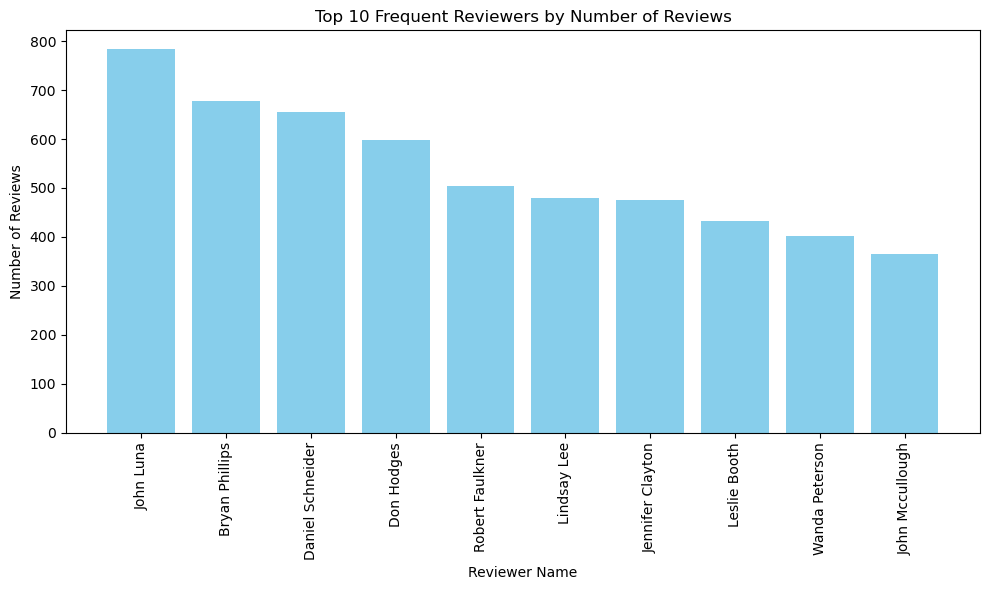

In [18]:
# Selecting the top 10 reviewers
top_10_reviewers = reviewer_counts.head(10)

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(top_10_reviewers.index, top_10_reviewers.values, color='skyblue')
plt.xticks(rotation=90)  # Rotating x-axis labels for better readability
plt.xlabel('Reviewer Name')
plt.ylabel('Number of Reviews')
plt.title('Top 10 Frequent Reviewers by Number of Reviews')
plt.tight_layout()
plt.show()

- We can see above the list of the 10 most frequent reviewers.

In [19]:
# Now let us look at the imbalance in the sentiment if there's any present

sentiment_count = train_copy['sentiment'].value_counts()
sentiment_count

POSITIVE    108761
NEGATIVE     53997
Name: sentiment, dtype: int64

In [20]:
sentiment_percent = sentiment_count/len(train) * 100
sentiment_percent

POSITIVE    66.823751
NEGATIVE    33.176249
Name: sentiment, dtype: float64

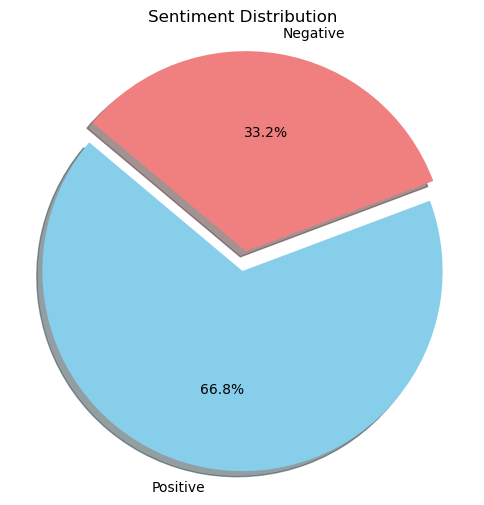

In [21]:
positive_percentage = 66.823751
negative_percentage = 33.176249

# Data for the pie chart
labels = ['Positive', 'Negative']
sizes = [positive_percentage, negative_percentage]
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)  # Explode the 'Positive' slice to highlight it

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sentiment Distribution')
plt.show()

- There's almost twice as much of POSTIVE sentimented reviews versus NEGATIVE sentimented reviews. This suggests class imbalance. 
- Applying class imbalance techniques like **SMOTE, RandomOverSampler, RandomUnderSampler or ADYSN** might be a good idea.

# Summary of Train dataset

> We have a total of **16758** entries in train dataset. Of these, there are **16812** unique **movieid** and there are **4482** unique reviewerName.

> About **3.9610 %** of reviewName column has null values.

> **John Luna** has reviewed the most, followed by **Bryan Phillips**

> The train dataset is **imbalanced** with **66.823751% Positive** sentiment reviews and **33.176249% Negative** sentimented reviews

## Test data

### Let us take a look at the train dataset

In [22]:
# A look at the test data

test_copy

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...
...,...,...,...,...
55310,celestial_radiant,Jose Mccormick,False,Ron Howard delivers an unconventional romantic...
55311,vivid_james_t._kirk,Thomas Osborne,False,As an oddball art film that openly invites you...
55312,scarlett_o'hara_neo_scarlett_o'hara_infinite,Julie Kirby,False,Nicholson wears his devilish grin from his fir...
55313,terminator_epic_rocky_balboa_mystic,Tina Sutton,True,It's hard not be entertained by two dozen of C...


- Shape of the test data is **(55315,4)**

In [23]:
missing_test = test_copy.isna().sum()
missing_test

movieid            0
reviewerName       0
isTopCritic        0
reviewText      2510
dtype: int64

In [24]:
missing_test_percent = missing_test/len(train)*100

print("Hence we see that the percentage of missing test['reviewText'] data  is:",missing_test_percent['reviewText'])

Hence we see that the percentage of missing test['reviewText'] data  is: 1.542166898094103


# Summary of Test dataset

> The dataset has a shape of **(55315,4)**.

> About **2510** entries or **1.542%** of reviewName column has null values.

# Data Pre-processing

In [25]:
#Initially we will encode the sentiment column in train dataset

label_encoder = LabelEncoder()
train_copy['sentiment'] = label_encoder.fit_transform(train_copy['sentiment'])

In [26]:
train_copy['isFrequentReviewer'] = label_encoder.fit_transform(train_copy['isFrequentReviewer'])

In [27]:
#Filling in the missing values

train_copy['reviewText'].fillna('missing', inplace=True)
train_copy.isna().sum()

movieid               0
reviewerName          0
isFrequentReviewer    0
reviewText            0
sentiment             0
dtype: int64

- We see there are no missing values in our train dataset now. Similarly we will do this for our test dataset

In [28]:
# Applying similar techniques for the test dataset

test_copy['reviewText'].fillna('missing', inplace=True)
test_copy.isna().sum()

movieid         0
reviewerName    0
isTopCritic     0
reviewText      0
dtype: int64

## Pre-processing Functions

#### Let us define some functions to clean up our reviewText column

___________________________________________________________________________________________________________________________________________

In [29]:
import re

# Function to cleanup the review column to prepare it for modeling
def clean_review(review):
    # Convert the review to lowercase
    review = str(review).lower()
    
    # Remove URLs
    review = re.sub(r'https?://\S+', '', review)
    
    # Remove HTML tags
    review = re.sub(r'<[^>]*>', '', review)
    
    # Remove newlines
    review = re.sub('\n', ' ', review)
    
    # Remove alphanumeric words and single letters
    review = re.sub(r'\b\w\b', '', review)
    
    # Remove punctuation, excluding specific characters
    review = re.sub(r'[^\w\s!@$%^&*(),.?":{}|<>]', '', review)
    
    # Remove numbers and apostrophes
    review = re.sub(r'\b\d+\b', '', review)
    review = re.sub(r"'", '', review)

    return review


# For train DataFrame
train_copy['reviewText'] = train_copy['reviewText'].apply(lambda x: clean_review(x))

In [30]:
# Define a function to remove stop words from the reviewText column

stop_words = ["0o","0s","3a","3b","3d","6b","6o","a","a1","a2","a3","a4","ab","able","about","above","abst","ac","accordance","according","accordingly","across","act","actually","ad","added","adj","ae","af","affected","affecting","affects","after","afterwards","ag","again","against","ah","ain","ain't","aj","al","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","amoungst","amount","an","and","announce","another","any","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","ao","ap","apart","apparently","appear","appreciate","appropriate","approximately","ar","are","aren","arent","aren't","arise","around","as","a's","aside","ask","asking","associated","at","au","auth","av","available","aw","away","awfully","ax","ay","az","b","b1","b2","b3","ba","back","bc","bd","be","became","because","become","becomes","becoming","been","before","beforehand","begin","beginning","beginnings","begins","behind","being","believe","below","beside","besides","best","better","between","beyond","bi","bill","biol","bj","bk","bl","bn","both","bottom","bp","br","brief","briefly","bs","bt","bu","but","bx","by","c","c1","c2","c3","ca","call","came","can","cannot","cant","can't","cause","causes","cc","cd","ce","certain","certainly","cf","cg","ch","changes","ci","cit","cj","cl","clearly","cm","c'mon","cn","co","com","come","comes","con","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn","couldnt","couldn't","course","cp","cq","cr","cry","cs","c's","ct","cu","currently","cv","cx","cy","cz","d","d2","da","date","dc","dd","de","definitely","describe","described","despite","detail","df","di","did","didn","didn't","different","dj","dk","dl","do","does","doesn","doesn't","doing","don","done","don't","down","downwards","dp","dr","ds","dt","du","due","during","dx","dy","e","e2","e3","ea","each","ec","ed","edu","ee","ef","effect","eg","ei","eight","eighty","either","ej","el","eleven","else","elsewhere","em","empty","en","end","ending","enough","entirely","eo","ep","eq","er","es","especially","est","et","et-al","etc","eu","ev","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","ey","f","f2","fa","far","fc","few","ff","fi","fifteen","fifth","fify","fill","find","fire","first","five","fix","fj","fl","fn","fo","followed","following","follows","for","former","formerly","forth","forty","found","four","fr","from","front","fs","ft","fu","full","further","furthermore","fy","g","ga","gave","ge","get","gets","getting","gi","give","given","gives","giving","gj","gl","go","goes","going","gone","got","gotten","gr","greetings","gs","gy","h","h2","h3","had","hadn","hadn't","happens","hardly","has","hasn","hasnt","hasn't","have","haven","haven't","having","he","hed","he'd","he'll","hello","help","hence","her","here","hereafter","hereby","herein","heres","here's","hereupon","hers","herself","hes","he's","hh","hi","hid","him","himself","his","hither","hj","ho","home","hopefully","how","howbeit","however","how's","hr","hs","http","hu","hundred","hy","i","i2","i3","i4","i6","i7","i8","ia","ib","ibid","ic","id","i'd","ie","if","ig","ignored","ih","ii","ij","il","i'll","im","i'm","immediate","immediately","importance","important","in","inasmuch","inc","indeed","index","indicate","indicated","indicates","information","inner","insofar","instead","interest","into","invention","inward","io","ip","iq","ir","is","isn","isn't","it","itd","it'd","it'll","its","it's","itself","iv","i've","ix","iy","iz","j","jj","jr","js","jt","ju","just","k","ke","keep","keeps","kept","kg","kj","km","know","known","knows","ko","l","l2","la","largely","last","lately","later","latter","latterly","lb","lc","le","least","les","less","lest","let","lets","let's","lf","like","liked","likely","line","little","lj","ll","ll","ln","lo","look","looking","looks","los","lr","ls","lt","ltd","m","m2","ma","made","mainly","make","makes","many","may","maybe","me","mean","means","meantime","meanwhile","merely","mg","might","mightn","mightn't","mill","million","mine","miss","ml","mn","mo","more","moreover","most","mostly","move","mr","mrs","ms","mt","mu","much","mug","must","mustn","mustn't","my","myself","n","n2","na","name","namely","nay","nc","nd","ne","near","nearly","necessarily","necessary","need","needn","needn't","needs","neither","never","nevertheless","new","next","ng","ni","nine","ninety","nj","nl","nn","no","nobody","non","none","nonetheless","noone","nor","normally","nos","not","noted","nothing","novel","now","nowhere","nr","ns","nt","ny","o","oa","ob","obtain","obtained","obviously","oc","od","of","off","often","og","oh","oi","oj","ok","okay","ol","old","om","omitted","on","once","one","ones","only","onto","oo","op","oq","or","ord","os","ot","other","others","otherwise","ou","ought","our","ours","ourselves","out","outside","over","overall","ow","owing","own","ox","oz","p","p1","p2","p3","page","pagecount","pages","par","part","particular","particularly","pas","past","pc","pd","pe","per","perhaps","pf","ph","pi","pj","pk","pl","placed","please","plus","pm","pn","po","poorly","possible","possibly","potentially","pp","pq","pr","predominantly","present","presumably","previously","primarily","probably","promptly","proud","provides","ps","pt","pu","put","py","q","qj","qu","que","quickly","quite","qv","r","r2","ra","ran","rather","rc","rd","re","readily","really","reasonably","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","research-articl","respectively","resulted","resulting","results","rf","rh","ri","right","rj","rl","rm","rn","ro","rq","rr","rs","rt","ru","run","rv","ry","s","s2","sa","said","same","saw","say","saying","says","sc","sd","se","sec","second","secondly","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","sf","shall","shan","shan't","she","shed","she'd","she'll","shes","she's","should","shouldn","shouldn't","should've","show","showed","shown","showns","shows","si","side","significant","significantly","similar","similarly","since","sincere","six","sixty","sj","sl","slightly","sm","sn","so","some","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","sp","specifically","specified","specify","specifying","sq","sr","ss","st","still","stop","strongly","sub","substantially","successfully","such","sufficiently","suggest","sup","sure","sy","system","sz","t","t1","t2","t3","take","taken","taking","tb","tc","td","te","tell","ten","tends","tf","th","than","thank","thanks","thanx","that","that'll","thats","that's","that've","the","their","theirs","them","themselves","then","thence","there","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","there's","thereto","thereupon","there've","these","they","theyd","they'd","they'll","theyre","they're","they've","thickv","thin","think","third","this","thorough","thoroughly","those","thou","though","thoughh","thousand","three","throug","through","throughout","thru","thus","ti","til","tip","tj","tl","tm","tn","to","together","too","took","top","toward","towards","tp","tq","tr","tried","tries","truly","try","trying","ts","t's","tt","tv","twelve","twenty","twice","two","tx","u","u201d","ue","ui","uj","uk","um","un","under","unfortunately","unless","unlike","unlikely","until","unto","uo","up","upon","ups","ur","us","use","used","useful","usefully","usefulness","uses","using","usually","ut","v","va","value","various","vd","ve","ve","very","via","viz","vj","vo","vol","vols","volumtype","vq","vs","vt","vu","w","wa","want","wants","was","wasn","wasnt","wasn't","way","we","wed","we'd","welcome","well","we'll","well-b","went","were","we're","weren","werent","weren't","we've","what","whatever","what'll","whats","what's","when","whence","whenever","when's","where","whereafter","whereas","whereby","wherein","wheres","where's","whereupon","wherever","whether","which","while","whim","whither","who","whod","whoever","whole","who'll","whom","whomever","whos","who's","whose","why","why's","wi","widely","will","willing","wish","with","within","without","wo","won","wonder","wont","won't","words","world","would","wouldn","wouldnt","wouldn't","www","x","x1","x2","x3","xf","xi","xj","xk","xl","xn","xo","xs","xt","xv","xx","y","y2","yes","yet","yj","yl","you","youd","you'd","you'll","your","youre","you're","yours","yourself","yourselves","you've","yr","ys","yt","z","zero","zi","zz"]


# Define the function to remove stop words from a single review
def remove_stop_words_from_review(review, stop_words):
    words = review.split()  # Tokenize the review into words
    filtered_words = [word for word in words if word.lower() not in stop_words]  # Remove stop words
    processed_review = ' '.join(filtered_words)  # Reconstruct the review without stop words
    return processed_review

In [31]:
train_copy.dtypes

movieid               object
reviewerName          object
isFrequentReviewer     int64
reviewText            object
sentiment              int64
dtype: object

In [32]:
train_copy['reviewText'] = train_copy['reviewText'].apply(lambda x: remove_stop_words_from_review(str(x), stop_words))

In [33]:
train_copy

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,0,henry selick movie coraline. stopmotion master...,1
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,0,"cast reads vogue oscar party guest list, valen...",0
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,1,"creed another, superior rocky sequel. wins poi...",1
3,lara_croft_glimmer,Ryan Barrett,0,"thinking, limitless (bradley cooper). cells mu...",1
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,0,director fernando meirelles tells story urgenc...,1
...,...,...,...,...,...
162753,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,0,"topnotch thriller genuine surprises great, aff...",1
162754,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,1,people derek zoolander funny likable endearing...,0
162755,infinite_enigma_luke_skywalker,Bryan Wilson,0,"fun, gentle comedy focuses themes families eas...",1
162756,emerald_oracle_iron_man_wolverine,Erik Parker,0,"film rescued strong act, torture.",0


____________________________________

In [34]:
#Let us look at the duplicates present in the train data

train_duplicate = train_copy[train_copy.duplicated(['movieid','reviewerName'],keep=False)]

train_duplicate.shape

(2929, 5)

In [35]:
#Grouping the duplicates together

train_duplicate.groupby(['movieid']).count()

,reviewerName,isFrequentReviewer,reviewText,sentiment
movieid,,,,
adventure_wondrous_dream_mystic,2,2,2,2
anakin_skywalker_hiccup_darth_vader_intrigue,2,2,2,2
annie_hall_black_widow_phenomenal,2,2,2,2
annie_hall_golden_jack_sparrow,25,25,25,25
annie_hall_han_solo_wondrous_captain_jack_sparrow,2,2,2,2
...,...,...,...,...
wolverine_trinity_harry_potter,2,2,2,2
wonder_enigma_scarlett_o'hara,2,2,2,2
wonder_sherlock_holmes_gandalf,2,2,2,2


In [36]:
adven = train_duplicate[train_duplicate['movieid'] == 'adventure_wondrous_dream_mystic']

# Grouping by 'reviewerName' and counting the occurrences
reviewer_counts = adven.groupby('reviewerName').count()

# Displaying the counts
print(reviewer_counts)


                 movieid  isFrequentReviewer  reviewText  sentiment
reviewerName                                                       
Brittany Medina        2                   2           2          2


In [37]:
# Checking for the shapes of the sentiments of the duplicates

train_duplicate[train_duplicate.sentiment == 1].shape, train_duplicate[train_duplicate.sentiment == 0].shape

((1980, 5), (949, 5))

In [38]:
## Let us clean up the test data now

test_copy['reviewText'] = test_copy['reviewText'].apply(lambda x: clean_review(x))
test_copy['reviewText'] = test_copy['reviewText'].apply(lambda x: remove_stop_words_from_review(str(x), stop_words))

In [39]:
test_copy

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,green slowly cranks dread style occasional sha...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,"philip noyce direction elegant unforced, admir..."
2,james_bond_labyrinth_gollum,Danielle Parker,False,path maria ultimately takes... lessen pleasure...
3,v_quest_han_solo_wondrous,Brittany Lane,False,"pig arthouse john wick synopsis suggest, stran..."
4,enigma_hulk_surreal_starlight,Justin Willis,False,imaginative nobudget musical sorts male samese...
...,...,...,...,...
55310,celestial_radiant,Jose Mccormick,False,ron howard delivers unconventional romantic co...
55311,vivid_james_t._kirk,Thomas Osborne,False,"oddball art film openly invites about, film la..."
55312,scarlett_o'hara_neo_scarlett_o'hara_infinite,Julie Kirby,False,"nicholson wears devilish grin scene last, assu..."
55313,terminator_epic_rocky_balboa_mystic,Tina Sutton,True,"hard entertained dozen cole best, sung winning..."


In [40]:
test_copy['isTopCritic'].value_counts()

False    38428
True     16887
Name: isTopCritic, dtype: int64

In [41]:
#Encoding the isTopCritic column in test data

test_copy['isTopCritic'] = label_encoder.fit_transform(test_copy['isTopCritic'])

## Movies dataset- a recap

In [42]:
movie_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


In [43]:
# Function to determine the total percentage of null values in a column

def null_value_percent(df):
    percent = round(df.isnull().sum() / len(df) * 100, ndigits=2)
    null_column_percent = pd.DataFrame(percent, columns=['Percent'])
    return null_column_percent


In [44]:
null_value_percent(movie_copy)

,Percent
movieid,0.00
title,0.00
audienceScore,48.87
rating,90.23
ratingContents,90.23
releaseDateTheaters,78.52
releaseDateStreaming,44.56
runtimeMinutes,9.65
genre,7.74
originalLanguage,9.67


- We will drop the columns having null values above 50%

In [45]:
movie_copy.describe(include='all')

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
count,143258,143258,73248.000000,13991,13991,30773,79420,129431.000000,132175,129400,143258,14743,23005,15917
unique,126404,126404,NaN,10,8353,12062,4726,NaN,2912,112,62208,4863,3694,551
top,escape_the_terminator_tyler_durden_astonish,Escape The Terminator Tyler Durden Astonish,NaN,R,['Language'],2018-09-14,2017-05-22,NaN,Drama,English,Joseph Brooks,$1.1M,Paramount Pictures,Surround
freq,367,367,NaN,7734,365,37,1232,NaN,27860,85034,4194,118,994,4075
mean,NaN,NaN,55.674967,NaN,NaN,NaN,NaN,93.708578,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,24.553648,NaN,NaN,NaN,NaN,28.129175,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,37.000000,NaN,NaN,NaN,NaN,84.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,57.000000,NaN,NaN,NaN,NaN,92.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,76.000000,NaN,NaN,NaN,NaN,103.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
movie_copy.movieid.value_counts()

escape_the_terminator_tyler_durden_astonish         367
silent_mystery_the_terminator                        17
crimson_james_t._kirk_marty_mcfly_hulk               17
darth_vader_dazzling_courageous_holly_golightly      16
rocky_balboa_wonder_woman_majestic_emerald           16
                                                   ... 
anakin_skywalker_frodo_baggins_t-800_black_widow      1
phantom_hannibal_lecter_don_vito_corleone_pirate      1
v_bruce_wayne_stardust                                1
mystery_lara_croft_tony_montana                       1
wonder_hermione_granger_hulk_v                        1
Name: movieid, Length: 126404, dtype: int64

From a previous discussion, we see that some of the null values have over 50% of missing data. Therefore we will drop these columns.

In [47]:
drop_col = ['rating','ratingContents','releaseDateTheaters','boxOffice','distributor','soundType']
drop_movie = movie_copy.drop(columns = drop_col)
drop_movie.head()

,movieid,title,audienceScore,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,2020-02-11,114.0,Drama,English,Nathan Haack
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,120.0,Drama,Korean,Theresa Smith
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms


In [48]:
drop_movie.shape

(143258, 8)

In [49]:
# Next let us drop the duplicates from the movies data
duplicate_movie = drop_movie.drop_duplicates('movieid')
duplicate_movie

,movieid,title,audienceScore,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,2020-02-11,114.0,Drama,English,Nathan Haack
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,120.0,Drama,Korean,Theresa Smith
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms
...,...,...,...,...,...,...,...,...
143252,james_bond_jason_bourne,James Bond Jason Bourne,NaN,2019-01-03,131.0,"Action, Mystery & thriller",Hindi,Reginald Davis
143253,sherlock_holmes_surreal_james_bond,Sherlock Holmes Surreal James Bond,14.0,NaN,90.0,"Action, Adventure, Anime",Japanese,William Sims
143254,mr._miyagi_katniss_everdeen_harmony,Mr. Miyagi Katniss Everdeen Harmony,NaN,NaN,99.0,Drama,English,Robert Paddock
143255,elegant_emerald_valiant_donnie_darko,Elegant Emerald Valiant Donnie Darko,71.0,NaN,43.0,Documentary,English,Roy Lovelace


## Merging train and movies dataset

In [50]:
merged_train_data = pd.merge(train_copy, duplicate_movie, on='movieid', how='inner')
merged_train_data.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,title,audienceScore,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director
0,marvelous_pirate,Benjamin Henry,0,henry selick movie coraline. stopmotion master...,1,Marvelous Pirate,65.0,2022-10-28,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso
1,marvelous_pirate,Sharon Foster,0,&&93he haphazard story assembled filmmakers co...,0,Marvelous Pirate,65.0,2022-10-28,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso
2,marvelous_pirate,Melinda Dunn,0,stopmotion artistry wendell &amp wild exquisit...,1,Marvelous Pirate,65.0,2022-10-28,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso
3,marvelous_pirate,Mr. Wayne Smith,0,wendell &amp wild narratively overstuffed limi...,0,Marvelous Pirate,65.0,2022-10-28,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso
4,marvelous_pirate,Connor Nelson,0,netherworlds& it& warm inviting&,1,Marvelous Pirate,65.0,2022-10-28,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso


In [51]:
merged_train_data.shape

(162758, 12)

In [52]:
null_value_percent(merged_train_data)

,Percent
movieid,0.00
reviewerName,0.00
isFrequentReviewer,0.00
reviewText,0.00
sentiment,0.00
title,0.00
audienceScore,8.14
releaseDateStreaming,9.94
runtimeMinutes,2.07
genre,1.50


> **Some columns still have null values and we need to fix them**

In [53]:
merged_train_data['audienceScore'].isna().sum()

13248

### Functions for imputation and plotting a histogram

____________________________________________________________________________________________________________________________________________________

In [54]:
from sklearn.impute import SimpleImputer

def impute_column_with_median(data, column):
    
    # Create the SimpleImputer with the desired strategy and fill_value (median)
    simple_imputer = SimpleImputer(strategy='median')
    
    # Reshape the column into a 2D array
    column_2d = data[column].values.reshape(-1, 1)
    
    # Impute the missing values using SimpleImputer
    imputed_column = simple_imputer.fit_transform(column_2d).flatten()
    
    # Update the DataFrame with the imputed column
    data[column] = imputed_column


In [55]:
def impute_column_with_most_frequent(data, column):
    
    # Create the SimpleImputer with the desired strategy (most_frequent)
    simple_imputer = SimpleImputer(strategy='most_frequent')
    
    # Reshape the column into a 2D array
    column_2d = data[column].values.reshape(-1, 1)
    
    # Impute the missing values using SimpleImputer
    imputed_column = simple_imputer.fit_transform(column_2d).flatten()
    
    # Update the DataFrame with the imputed column
    data[column] = imputed_column


In [56]:
def plot_histogram(data, column, bins=10, edgecolor='black'):
    
    # Extract the column data
    column_data = data[column]

    # Plot the distribution using a histogram
    plt.hist(column_data, bins=bins, edgecolor=edgecolor)

    # Set the labels and title
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column}')

    # Display the plot
    plt.show()


__________________________________________________________________________________________________________________________________________________

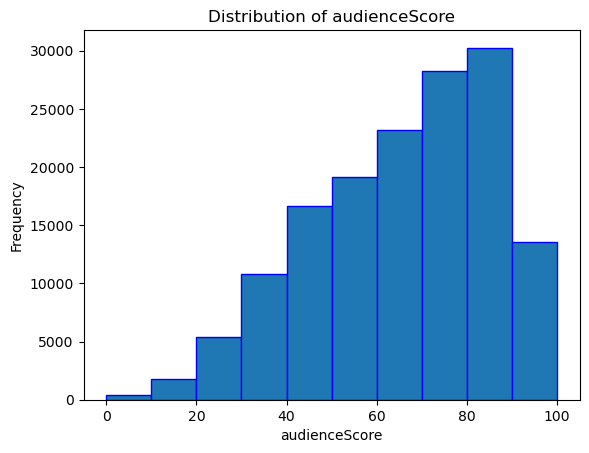

In [57]:
#Plotting the histogram before imputation for audienceScore

plot_histogram(merged_train_data, 'audienceScore', bins=10, edgecolor='blue')

In [58]:
impute_column_with_median(merged_train_data, 'audienceScore')

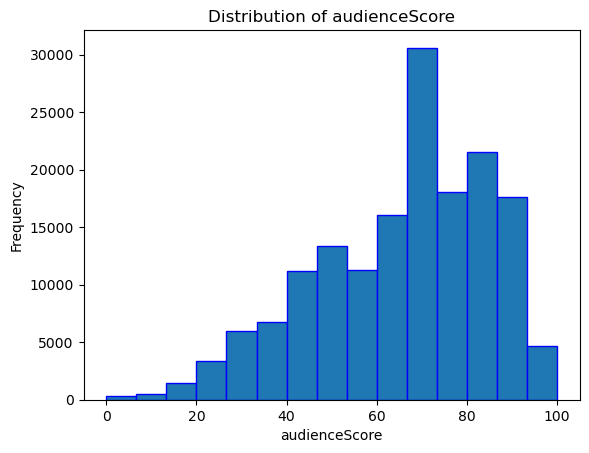

In [59]:
#Plotting the histogram after imputation for audienceScore

plot_histogram(merged_train_data, 'audienceScore', bins=15, edgecolor='blue')

> **We see that the distribution is maintained when using the median strategy except the fact that there is a spike at the median value**

In [60]:
null_value_percent(merged_train_data)

,Percent
movieid,0.00
reviewerName,0.00
isFrequentReviewer,0.00
reviewText,0.00
sentiment,0.00
title,0.00
audienceScore,0.00
releaseDateStreaming,9.94
runtimeMinutes,2.07
genre,1.50


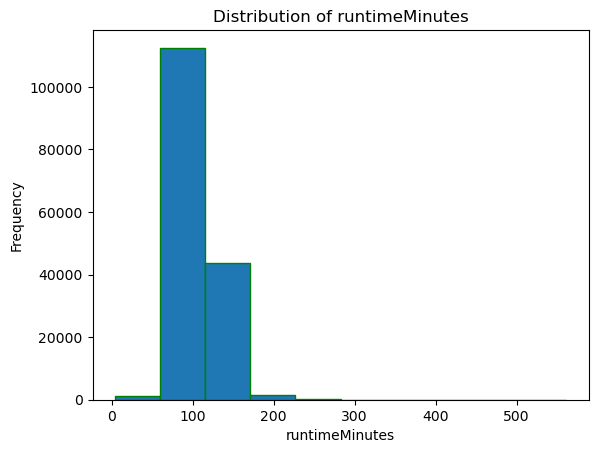

In [61]:
#Plotting the histogram before imputation for runtimeMinutes
plot_histogram(merged_train_data, 'runtimeMinutes', bins=10, edgecolor='green')

In [62]:
impute_column_with_median(merged_train_data, 'runtimeMinutes')

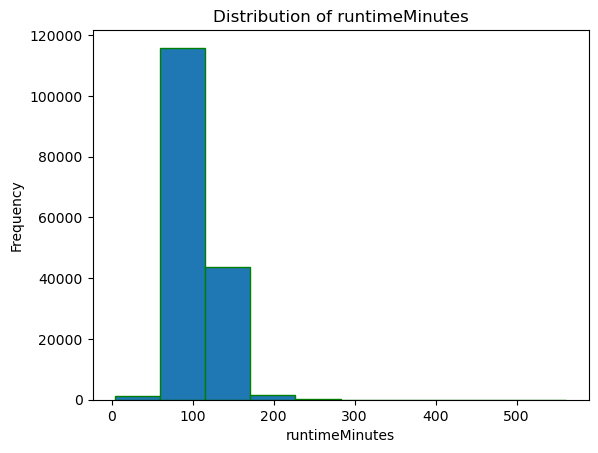

In [63]:
#Plotting the histogram after imputation for runtimeMinutes
plot_histogram(merged_train_data, 'runtimeMinutes', bins=10, edgecolor='green')

In [64]:
merged_train_data.originalLanguage.value_counts()

English                     132617
French (France)               3341
English (United Kingdom)      3258
French (Canada)               2241
Japanese                      1904
                             ...  
Gujarati                         3
Slovenian                        2
Somali                           2
Latvian                          1
Azerbaijani                      1
Name: originalLanguage, Length: 91, dtype: int64

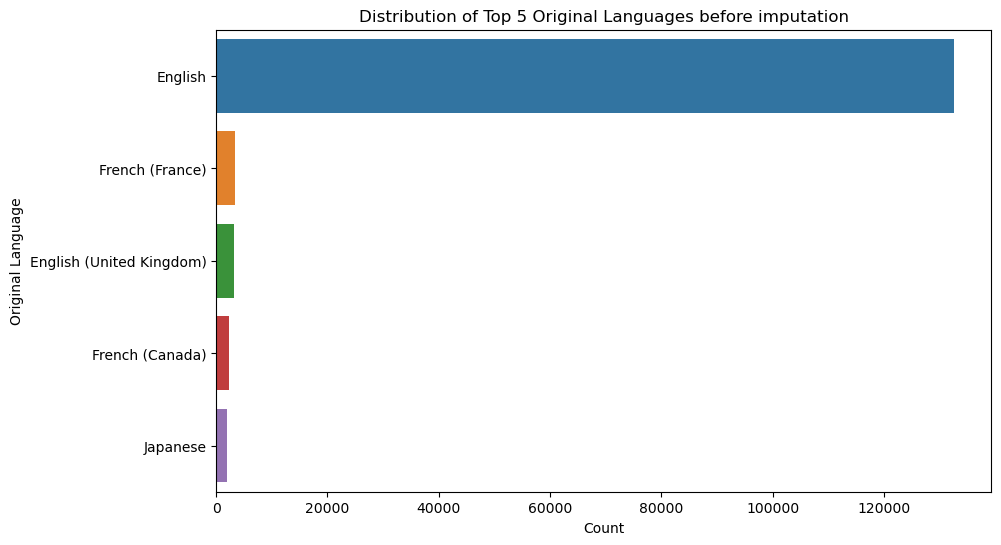

In [65]:
# Before imputation

# Get the value counts of each language
language_counts = merged_train_data['originalLanguage'].value_counts()

# Extract the top 5 languages
top_5_languages = language_counts.head(5)

# Plot the countplot for the top 5 languages
plt.figure(figsize=(10, 6))  
sns.countplot(y='originalLanguage', data=merged_train_data, order=top_5_languages.index)

# Set the labels and title
plt.xlabel('Count')
plt.ylabel('Original Language')
plt.title('Distribution of Top 5 Original Languages before imputation')

# Display the plot
plt.show()

In [66]:
impute_column_with_most_frequent(merged_train_data, 'originalLanguage')

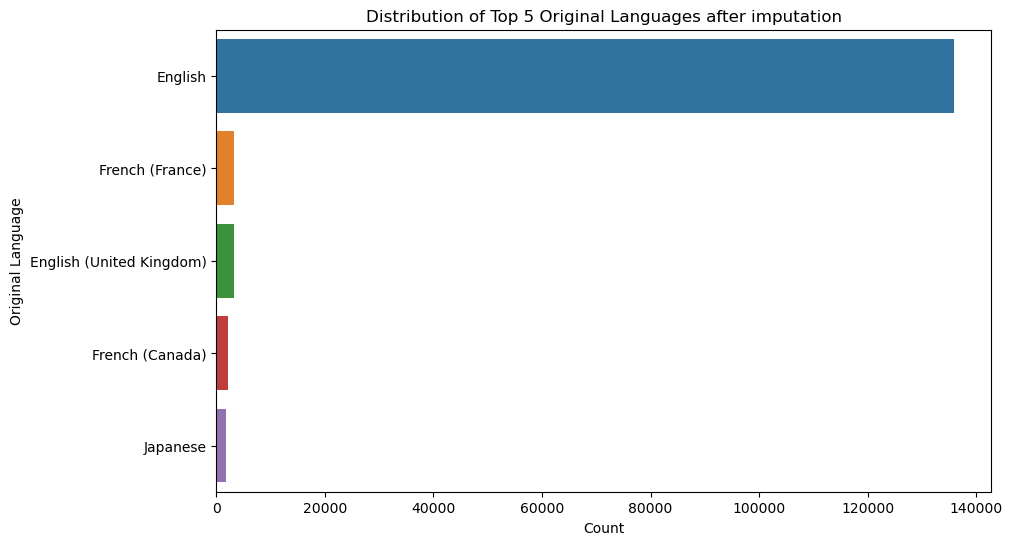

In [67]:
# After imputation

# Get the value counts of each language
language_counts = merged_train_data['originalLanguage'].value_counts()

# Extract the top 5 languages
top_5_languages = language_counts.head(5)

# Plot the countplot for the top 5 languages
plt.figure(figsize=(10, 6))  
sns.countplot(y='originalLanguage', data=merged_train_data, order=top_5_languages.index)

# Set the labels and title
plt.xlabel('Count')
plt.ylabel('Original Language')
plt.title('Distribution of Top 5 Original Languages after imputation')

# Display the plot
plt.show()

- The graph above tells us about the **top 5** most frequently occurring languages in the OriginalLanguages column which shows that most of the reviews are in **English**. The graph above is plotted after imputing the missing values with the most_frequent strategy.

In [68]:
merged_train_data.genre.value_counts()

Drama                                               24159
Comedy                                              11252
Documentary                                          9805
Comedy, Drama                                        9775
Mystery & thriller                                   5012
                                                    ...  
Fantasy, Lgbtq+, Musical                                1
Action, Comedy, Animation                               1
Western, Adventure, Romance                             1
Action, Comedy, Foreign                                 1
Action, Crime, Drama, Horror, Mystery & thriller        1
Name: genre, Length: 1162, dtype: int64

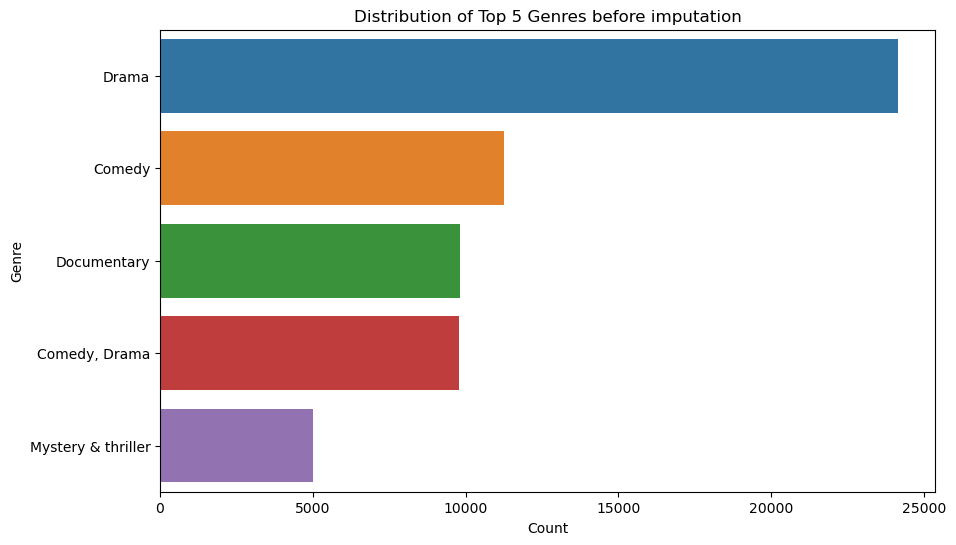

In [69]:
# Before imputation

# Get the value counts of each language
language_counts = merged_train_data['genre'].value_counts()

# Extract the top 5 languages
top_5_languages = language_counts.head(5)

# Plot the countplot for the top 5 languages
plt.figure(figsize=(10, 6))  
sns.countplot(y='genre', data=merged_train_data, order=top_5_languages.index)

# Set the labels and title
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Distribution of Top 5 Genres before imputation')

# Display the plot
plt.show()

In [70]:

impute_column_with_most_frequent(merged_train_data, 'genre')

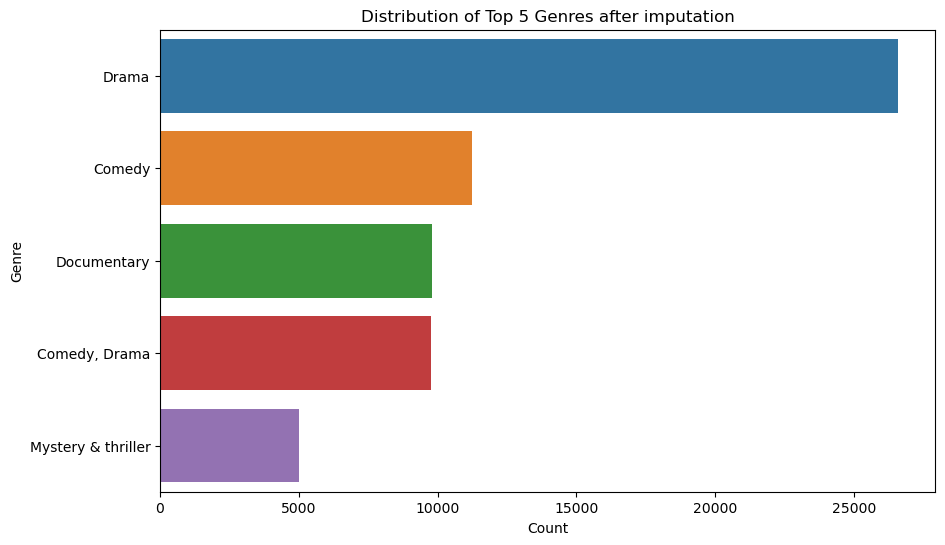

In [71]:
# After  imputation

# Get the value counts of each language
language_counts = merged_train_data['genre'].value_counts()

# Extract the top 5 languages
top_5_languages = language_counts.head(5)

# Plot the countplot for the top 5 languages
plt.figure(figsize=(10, 6))  
sns.countplot(y='genre', data=merged_train_data, order=top_5_languages.index)

# Set the labels and title
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Distribution of Top 5 Genres after imputation')

# Display the plot
plt.show()

In [72]:
merged_train_data.releaseDateStreaming.value_counts()

2017-05-22    653
2019-08-27    644
2004-10-12    373
2010-08-17    344
2004-09-07    316
             ... 
2014-10-20      1
2015-12-06      1
2022-02-02      1
2022-05-01      1
2011-06-13      1
Name: releaseDateStreaming, Length: 2899, dtype: int64

     releaseDateStreaming  movieid
1585           2017-05-22      653
2101           2019-08-27      644
410            2004-10-12      373
823            2010-08-17      344
404            2004-09-07      316
766            2009-11-03      308
2123           2019-10-11      303
1986           2019-02-19      303
654            2008-05-06      291
925            2011-10-11      282


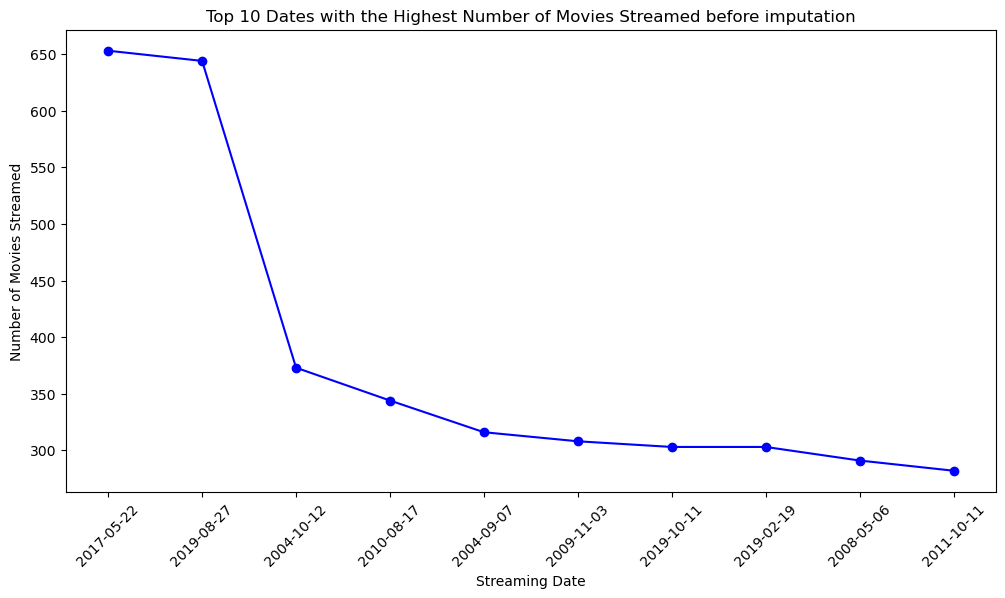

In [73]:
# Group the data by 'streaming_date' and count the number of movies on each date
movies_streamed_by_date = merged_train_data['movieid'].groupby(merged_train_data['releaseDateStreaming']).count()

# Reset the index to convert the groupby result into a DataFrame
movies_streamed_by_date = movies_streamed_by_date.reset_index()

# Sort the DataFrame by count of movies in descending order
movies_streamed_by_date_sorted = movies_streamed_by_date.sort_values(by='movieid', ascending=False)

# Select the top 10 dates with the highest number of movies streamed
top_10_dates = movies_streamed_by_date_sorted.head(10)

# Display the top 10 dates
print(top_10_dates)

# Plot the line plot for the top 10 dates
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed for better visibility
plt.plot(top_10_dates['releaseDateStreaming'], top_10_dates['movieid'], marker='o', linestyle='-', color='b')

# Set the labels and title
plt.xlabel('Streaming Date')
plt.ylabel('Number of Movies Streamed')
plt.title('Top 10 Dates with the Highest Number of Movies Streamed before imputation')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


In [74]:
impute_column_with_most_frequent(merged_train_data, 'releaseDateStreaming')

     releaseDateStreaming  movieid
1585           2017-05-22    16838
2101           2019-08-27      644
410            2004-10-12      373
823            2010-08-17      344
404            2004-09-07      316
766            2009-11-03      308
2123           2019-10-11      303
1986           2019-02-19      303
654            2008-05-06      291
925            2011-10-11      282


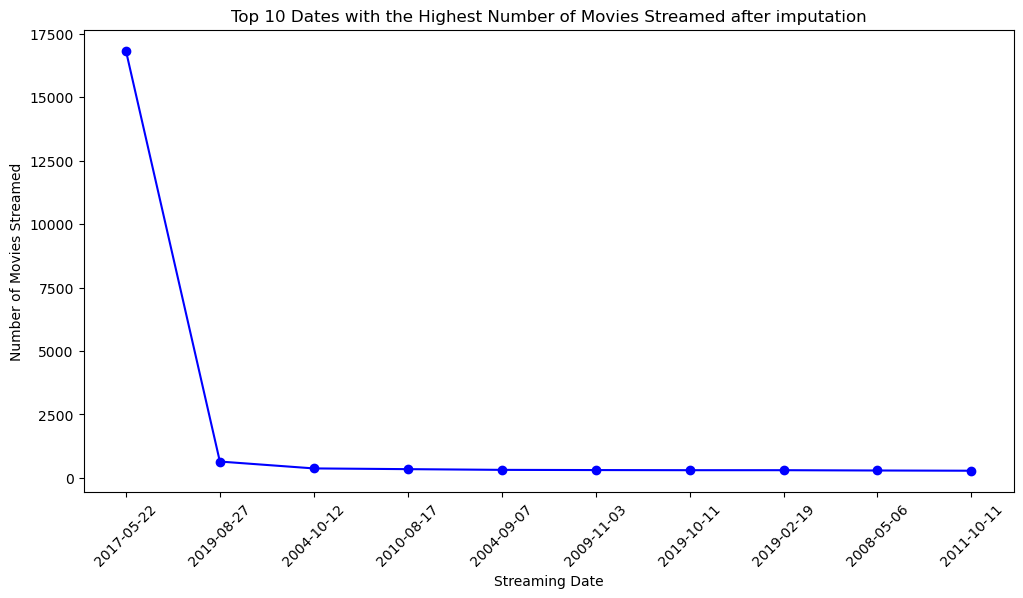

In [75]:
# Group the data by 'streaming_date' and count the number of movies on each date
movies_streamed_by_date = merged_train_data['movieid'].groupby(merged_train_data['releaseDateStreaming']).count()

# Reset the index to convert the groupby result into a DataFrame
movies_streamed_by_date = movies_streamed_by_date.reset_index()

# Sort the DataFrame by count of movies in descending order
movies_streamed_by_date_sorted = movies_streamed_by_date.sort_values(by='movieid', ascending=False)

# Select the top 10 dates with the highest number of movies streamed
top_10_dates = movies_streamed_by_date_sorted.head(10)

# Display the top 10 dates
print(top_10_dates)

# Plot the line plot for the top 10 dates
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed for better visibility
plt.plot(top_10_dates['releaseDateStreaming'], top_10_dates['movieid'], marker='o', linestyle='-', color='b')

# Set the labels and title
plt.xlabel('Streaming Date')
plt.ylabel('Number of Movies Streamed')
plt.title('Top 10 Dates with the Highest Number of Movies Streamed after imputation')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


In [76]:
null_value_percent(merged_train_data)

,Percent
movieid,0.0
reviewerName,0.0
isFrequentReviewer,0.0
reviewText,0.0
sentiment,0.0
title,0.0
audienceScore,0.0
releaseDateStreaming,0.0
runtimeMinutes,0.0
genre,0.0


In [77]:
merged_sentiment_count = merged_train_data['sentiment'].value_counts()
merged_sentiment_count

merged_sentiment_percent = merged_sentiment_count/len(merged_train_data) * 100
merged_sentiment_percent



1    66.823751
0    33.176249
Name: sentiment, dtype: float64

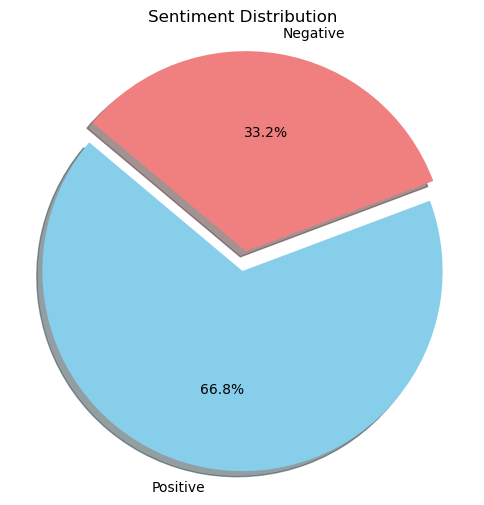

In [78]:
positive_percentage = 66.823751
negative_percentage = 33.176249

# Data for the pie chart
labels = ['Positive', 'Negative']
sizes = [positive_percentage, negative_percentage]
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)  

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sentiment Distribution')
plt.show()

- We notice the **imbalance is maintained** even in the merged training and movies dataset.

Text(0.5, 1.0, 'How Audience Score affects the sentiment ')

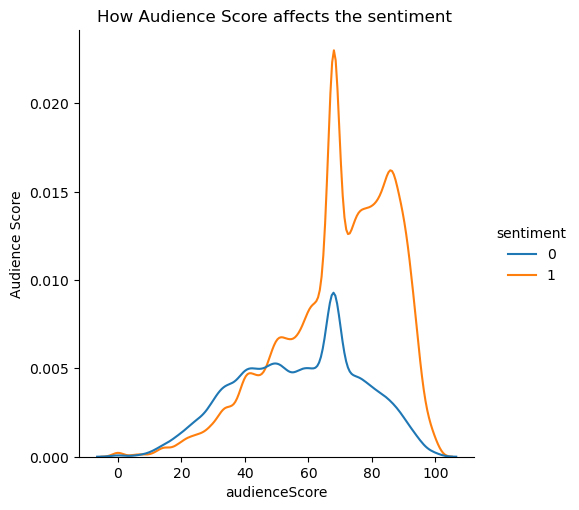

In [79]:
sns.displot(data=merged_train_data, x='audienceScore', hue='sentiment', kind='kde')
# Set the labels and title
#plt.xlabel('Sentiment')
plt.ylabel('Audience Score')
plt.title('How Audience Score affects the sentiment ')

Text(0.5, 1.0, 'How runtime Minutes affects the sentiment ')

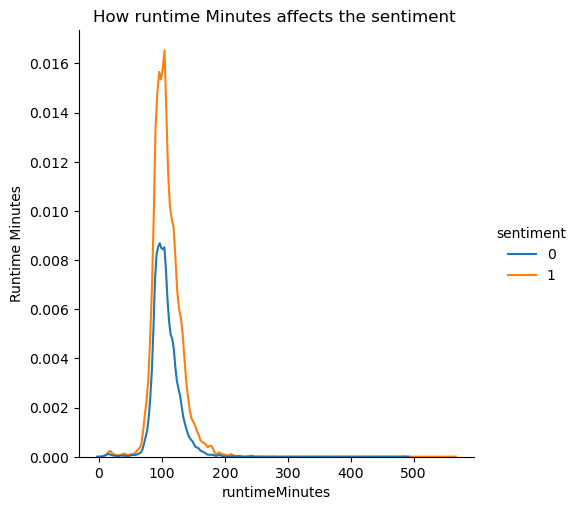

In [80]:
sns.displot(data=merged_train_data, x='runtimeMinutes', hue='sentiment', kind='kde')
# Set the labels and title
#plt.label('Sentiment')
plt.ylabel('Runtime Minutes')
plt.title('How runtime Minutes affects the sentiment ')

## Summary

> The missing values were **Imputed** for the various columns.

> **English** was the most frequently used languages,

> Most movies were **Drama** based.

> The **data imbalance** is conserved in the merged movies and train dataset.

> There seems to be a correlation between **audienceScore** and **sentiment** as well as **runtimeMinutes** and **sentiment**

## Merging test and movies dataset

In [81]:
merged_test_data = pd.merge(test_copy, duplicate_movie, on='movieid', how='left')
merged_test_data.head()

,movieid,reviewerName,isTopCritic,reviewText,title,audienceScore,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director
0,legend_marty_mcfly_oracle,John Kim,0,green slowly cranks dread style occasional sha...,Legend Marty McFly Oracle,57.0,2022-10-14,111.0,"Holiday, Horror, Mystery & thriller",English,Sara Barnett
1,terminator_katniss_everdeen_glimmer,Brian Chaney,0,"philip noyce direction elegant unforced, admir...",Terminator Katniss Everdeen Glimmer,86.0,2003-04-15,94.0,"Drama, Adventure",English,Cindy Flander
2,james_bond_labyrinth_gollum,Danielle Parker,0,path maria ultimately takes... lessen pleasure...,James Bond Labyrinth Gollum,62.0,NaN,NaN,Drama,French,Charlotte Bramble
3,v_quest_han_solo_wondrous,Brittany Lane,0,"pig arthouse john wick synopsis suggest, stran...",V Quest Han Solo Wondrous,84.0,2021-08-03,92.0,"Drama, Mystery & thriller",English,Jean Gainer
4,enigma_hulk_surreal_starlight,Justin Willis,0,imaginative nobudget musical sorts male samese...,Enigma Hulk Surreal Starlight,NaN,NaN,66.0,"Drama, Musical",Arabic,Marvin Short


In [82]:
merged_test_data.shape

(55315, 11)

In [83]:
null_value_percent(merged_test_data)

,Percent
movieid,0.00
reviewerName,0.00
isTopCritic,0.00
reviewText,0.00
title,0.00
audienceScore,8.91
releaseDateStreaming,10.80
runtimeMinutes,2.28
genre,1.66
originalLanguage,2.24


In [84]:
# Using the same imputations technique used in the merged_train_dataset to handle missing values in merged_train_dataset

impute_column_with_median(merged_test_data, 'audienceScore')

impute_column_with_most_frequent(merged_test_data, 'releaseDateStreaming')

impute_column_with_most_frequent(merged_test_data, 'genre')

impute_column_with_most_frequent(merged_test_data, 'originalLanguage')

impute_column_with_median(merged_test_data, 'runtimeMinutes')


In [85]:
null_value_percent(merged_test_data)

,Percent
movieid,0.0
reviewerName,0.0
isTopCritic,0.0
reviewText,0.0
title,0.0
audienceScore,0.0
releaseDateStreaming,0.0
runtimeMinutes,0.0
genre,0.0
originalLanguage,0.0


> We have **removed all the missing values** from our **merged training and test dataset**. We can move forward to splitting the dataset for further treatment

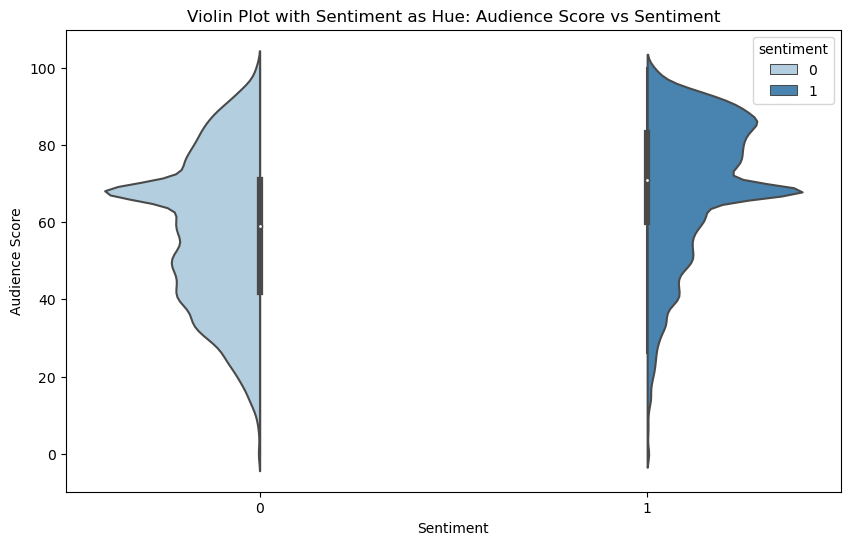

In [86]:
# Create the violin plot with sentiment as hue
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed for better visibility
sns.violinplot(data=merged_train_data, x='sentiment', y='audienceScore', hue='sentiment', palette='Blues', split=True)

# Set the labels and title
plt.xlabel('Sentiment')
plt.ylabel('Audience Score')
plt.title('Violin Plot with Sentiment as Hue: Audience Score vs Sentiment')

# Display the plot
plt.show()

### Scaling our data

In [87]:
# Use MinMax Scaler to scale the runtimeMinutes and audienceScore columns

from sklearn.preprocessing import MinMaxScaler

def min_max_scale(data, column):
    
    # Create the MinMaxScaler
    min_max_scaler = MinMaxScaler()
    
    # Reshape the column into a 2D array
    column_2d = data[column].values.reshape(-1, 1)
    
    # Apply Min-Max Scaling to the column in-place
    data[column] = min_max_scaler.fit_transform(column_2d)


In [88]:
# Scaling the columns of audienceScore, runtimeMinutes for both merged training and test data
min_max_scale(merged_train_data,'audienceScore')
min_max_scale(merged_train_data,'runtimeMinutes')


min_max_scale(merged_test_data,'audienceScore')
min_max_scale(merged_test_data,'runtimeMinutes')


# Splitting our dataset

In [89]:
# splitting the merged dataset into train and test set

merge_train, merge_test = train_test_split(merged_train_data, test_size = 0.2, stratify= merged_train_data.sentiment, random_state = 10)
merge_train.shape, merge_test.shape

((130206, 12), (32552, 12))

In [90]:
positive_train = merge_train[merge_train.sentiment==1]
negative_train = merge_train[merge_train.sentiment==0]


positive_test = merge_test[merge_test.sentiment==1]
negative_test = merge_test[merge_test.sentiment==0]


In [91]:
#Check imbalance

(positive_train.shape,negative_train.shape),(positive_test.shape,negative_test.shape)


(((87009, 12), (43197, 12)), ((21752, 12), (10800, 12)))

In [92]:
positive_train.describe()

,isFrequentReviewer,sentiment,audienceScore,runtimeMinutes
count,87009.000000,87009.0,87009.000000,87009.000000
mean,0.286982,1.0,0.694909,0.185889
std,0.452356,0.0,0.176368,0.040235
min,0.000000,1.0,0.000000,0.001795
25%,0.000000,1.0,0.600000,0.161580
50%,0.000000,1.0,0.710000,0.179533
75%,1.000000,1.0,0.830000,0.206463
max,1.000000,1.0,1.000000,1.000000


In [93]:
negative_train.describe()

,isFrequentReviewer,sentiment,audienceScore,runtimeMinutes
count,43197.000000,43197.0,43197.000000,43197.000000
mean,0.335787,0.0,0.571936,0.182093
std,0.472270,0.0,0.193660,0.036509
min,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.0,0.420000,0.159785
50%,0.000000,0.0,0.590000,0.177738
75%,1.000000,0.0,0.710000,0.199282
max,1.000000,0.0,1.000000,0.863555


In [94]:
positive_test.describe()

,isFrequentReviewer,sentiment,audienceScore,runtimeMinutes
count,21752.000000,21752.0,21752.000000,21752.000000
mean,0.292479,1.0,0.695065,0.186281
std,0.454912,0.0,0.177242,0.041489
min,0.000000,1.0,0.000000,0.010772
25%,0.000000,1.0,0.600000,0.161580
50%,0.000000,1.0,0.710000,0.179533
75%,1.000000,1.0,0.840000,0.206463
max,1.000000,1.0,1.000000,1.000000


In [95]:
negative_test.describe()

,isFrequentReviewer,sentiment,audienceScore,runtimeMinutes
count,10800.000000,10800.0,10800.000000,10800.000000
mean,0.345556,0.0,0.576170,0.181652
std,0.475571,0.0,0.193471,0.037790
min,0.000000,0.0,0.000000,0.001795
25%,0.000000,0.0,0.430000,0.159785
50%,0.000000,0.0,0.590000,0.177738
75%,1.000000,0.0,0.710000,0.199282
max,1.000000,0.0,1.000000,0.863555


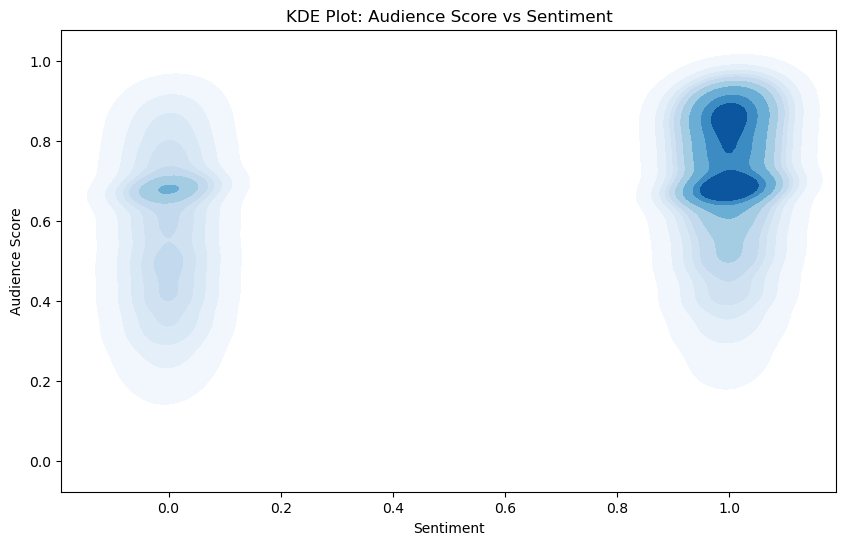

In [96]:
# Plot the KDE plot
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed for better visibility
sns.kdeplot(data=merged_train_data, x='sentiment', y='audienceScore', cmap='Blues', fill=True)

# Set the labels and title
plt.xlabel('Sentiment')
plt.ylabel('Audience Score')
plt.title('KDE Plot: Audience Score vs Sentiment')

# Display the plot
plt.show()

<Axes: >

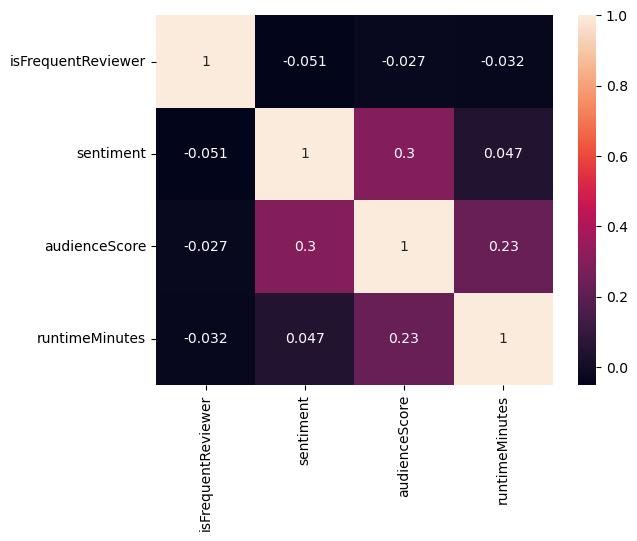

In [97]:
sns.heatmap(merged_train_data.corr(numeric_only=True),annot=True)

> **audienceScore** and **runtimeMinutes** seems to be correlated and is correlated to **sentiment** as well.

In [98]:
merged_train_data= merged_train_data.drop(columns = ['movieid','reviewerName','isFrequentReviewer','title','releaseDateStreaming','genre','originalLanguage','director'],axis=1)
merged_train_data

,reviewText,sentiment,audienceScore,runtimeMinutes
0,henry selick movie coraline. stopmotion master...,1,0.65,0.181329
1,&&93he haphazard story assembled filmmakers co...,0,0.65,0.181329
2,stopmotion artistry wendell &amp wild exquisit...,1,0.65,0.181329
3,wendell &amp wild narratively overstuffed limi...,0,0.65,0.181329
4,netherworlds& it& warm inviting&,1,0.65,0.181329
...,...,...,...,...
162753,"broad shape predictable time it, write final c...",0,0.81,0.192101
162754,formula designed adolescent young adult specta...,1,0.75,0.159785
162755,"years, soft spot heart it, clumsy glory. good ...",0,0.55,0.165171
162756,powerful documentary struggle west virginians ...,1,0.75,0.152603


In [99]:
X = merged_train_data[['reviewText', 'audienceScore', 'runtimeMinutes']]
y = merged_train_data['sentiment']


In [100]:
X.shape,y.shape

((162758, 3), (162758,))

In [101]:
# Split the data into training and testing sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)

In [102]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((130206, 3), (32552, 3), (130206,), (32552,))

## Evaluation metrics functions

_________________________________________________________________________________________________________________________________________________

In [103]:
#Function to print the classification report as well as the F1 scire and classification matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def report(X_test, y_test, pipeline):
    # Check if the pipeline has a best_estimator_ attribute (for GridSearchCV)
    if hasattr(pipeline, 'best_estimator_'):
        best_estimator = pipeline.best_estimator_
        y_pred = best_estimator.predict(X_test)
    else:
        y_pred = pipeline.predict(X_test)

    # Print the classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    print("-------------------------------------------------------------")

    # Calculate and print the F1 score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)
    print("-------------------------------------------------------------")

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


In [104]:
#Function to plot the ROC curve and ROC AUC score


from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(y_true, y_prob):
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_true, y_prob)

    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    # Plot ROC AUC curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.fill_between(fpr, tpr, alpha=0.5, color='lightblue')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    plt.show()

    # Print ROC AUC score
    print(f"ROC AUC: {roc_auc:.2f}")


In [105]:
def test_report(y_test, y_pred):
    # Print the classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [106]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer

def plot_precision_recall_curve_for_pipeline(pipeline, classifier_step, X_train, y_train):
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities on the training data
    if hasattr(pipeline.named_steps[classifier_step], 'predict_proba'):
        y_scores = pipeline.predict_proba(X_train)[:, 1]
    else:
        y_scores = pipeline.decision_function(X_train)
    
    # Calculate precision-recall values
    precision, recall, _ = precision_recall_curve(y_train, y_scores)
    
    # Calculate area under the curve (AUC)
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', label='Precision-Recall curve (AUC = {:.2f})'.format(pr_auc))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()




_________________________________________________________________________________________________________________________________________________

# Modelling

In [108]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

# Define the tfidf_transformer
tfidf_transformer = TfidfVectorizer()

# Define the numeric_transformer
numeric_transformer = MinMaxScaler()

tfidf_column = 'reviewText'  # No list here
numeric_columns = ['audienceScore', 'runtimeMinutes']

preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf_transformer, tfidf_column),  # No list here
        ('numeric', numeric_transformer, numeric_columns)
    ])

## Logistic Regression

In [109]:
from sklearn.pipeline import Pipeline


In [110]:
# Create the pipeline with preprocessor and Linear Regression
pipe_log = Pipeline([
    ('preprocessor', preprocessor),
    ('logit', LogisticRegression(max_iter=1000))
])

In [111]:
# Fit the pipeline on the training data
pipe_log.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(),
                                                  'reviewText'),
                                                 ('numeric', MinMaxScaler(),
                                                  ['audienceScore',
                                                   'runtimeMinutes'])])),
                ('logit', LogisticRegression(max_iter=1000))])

In [112]:
# Make predictions on the test data
y_pred_test = pipe_log.predict(X_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.58      0.66     10800
           1       0.81      0.91      0.86     21752

    accuracy                           0.80     32552
   macro avg       0.79      0.75      0.76     32552
weighted avg       0.80      0.80      0.79     32552

-------------------------------------------------------------
F1 Score: 0.8597332176553518
-------------------------------------------------------------


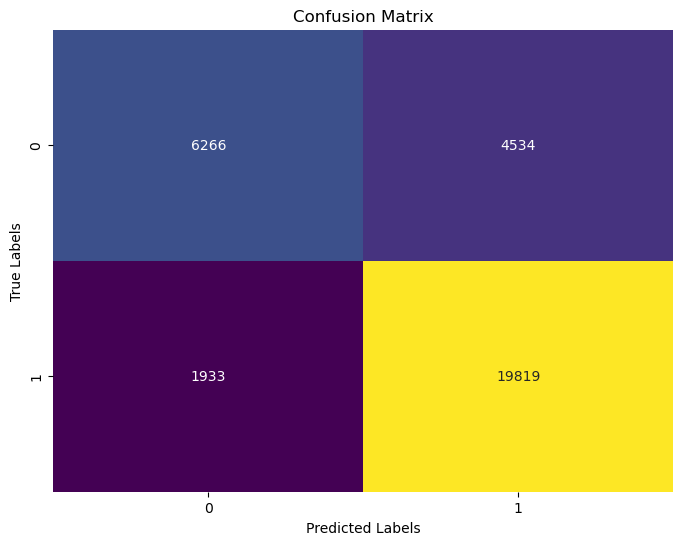

In [113]:
# Evaluate the model on the test data
report(X_test, y_test, pipe_log)

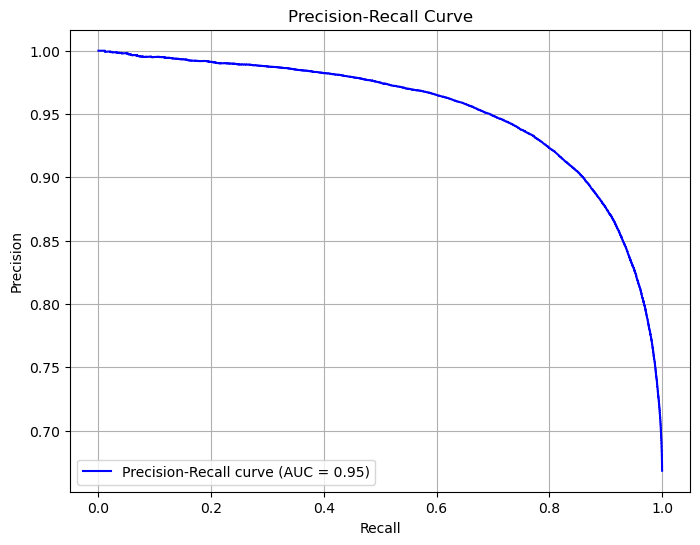

In [114]:
# Assuming you have X_train and y_train defined
plot_precision_recall_curve_for_pipeline(pipe_log, 'logit', X_train, y_train)

## NaiveBayes

> ### Multinomial Naive Bayes

In [115]:
from sklearn.naive_bayes import MultinomialNB
# Create a pipeline for Naive Bayes classifier
pipe_nb = Pipeline([
    ('preprocessor', preprocessor),
    ('nb', MultinomialNB())
])

In [116]:
# Fit the pipeline on the training data
pipe_nb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(),
                                                  'reviewText'),
                                                 ('numeric', MinMaxScaler(),
                                                  ['audienceScore',
                                                   'runtimeMinutes'])])),
                ('nb', MultinomialNB())])

In [117]:
# Predict the labels on the test data
y_pred = pipe_nb.predict(X_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.25      0.39     10800
           1       0.73      0.98      0.84     21752

    accuracy                           0.74     32552
   macro avg       0.81      0.62      0.61     32552
weighted avg       0.78      0.74      0.69     32552

-------------------------------------------------------------
F1 Score: 0.8357696286032124
-------------------------------------------------------------


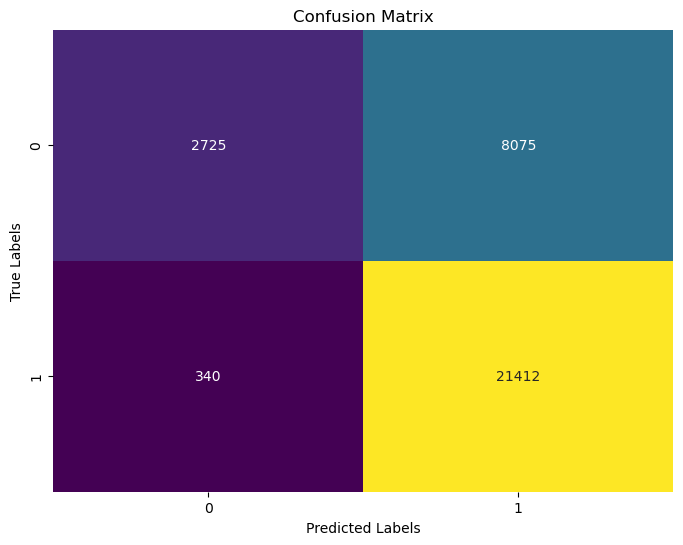

In [118]:
report(X_test, y_test, pipe_nb)

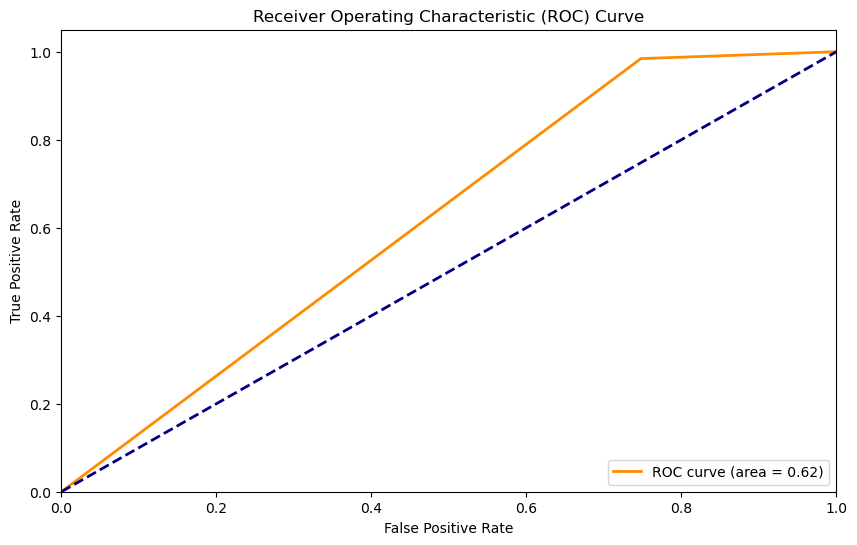

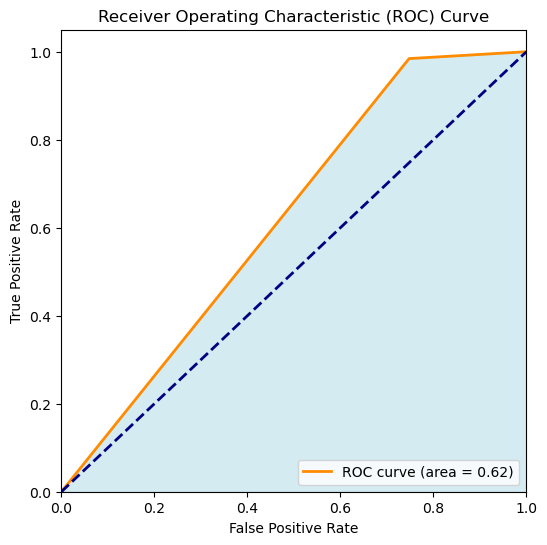

ROC AUC: 0.62


In [119]:
y_pred_prob = pipe_nb.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test,y_pred)

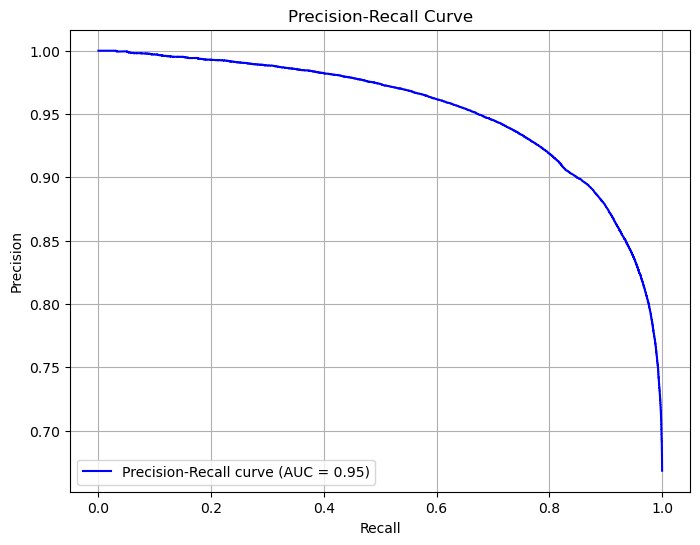

In [120]:
# Assuming you have X_train and y_train defined
plot_precision_recall_curve_for_pipeline(pipe_nb, 'nb', X_train, y_train)

> ### Complement NB

In [121]:
from sklearn.naive_bayes import ComplementNB
# Create a pipeline for Naive Bayes classifier
pipe_cnb = Pipeline([
    ('preprocessor', preprocessor),
    ('nb', ComplementNB())
])

In [122]:
# Fit the pipeline on the training data
pipe_cnb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(),
                                                  'reviewText'),
                                                 ('numeric', MinMaxScaler(),
                                                  ['audienceScore',
                                                   'runtimeMinutes'])])),
                ('nb', ComplementNB())])

In [123]:
# Predict the labels on the test data
y_pred = pipe_cnb.predict(X_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.55      0.64     10800
           1       0.80      0.91      0.85     21752

    accuracy                           0.79     32552
   macro avg       0.78      0.73      0.75     32552
weighted avg       0.79      0.79      0.78     32552

-------------------------------------------------------------
F1 Score: 0.8530230750965958
-------------------------------------------------------------


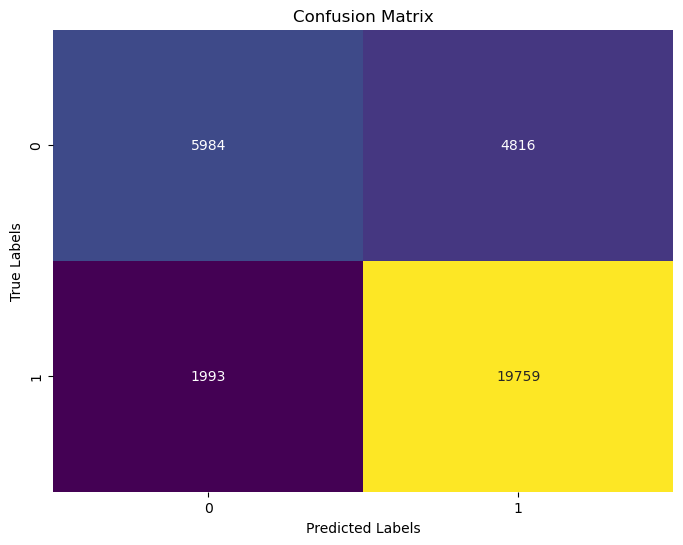

In [124]:
report(X_test, y_test, pipe_cnb)

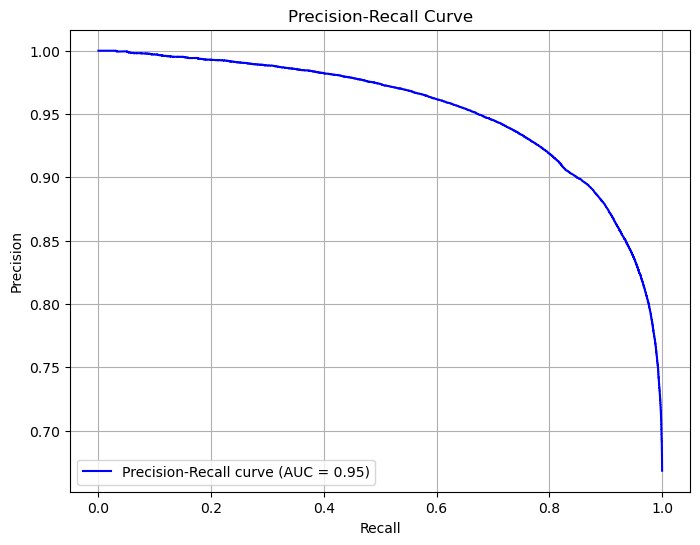

In [125]:
# Assuming you have X_train and y_train defined
plot_precision_recall_curve_for_pipeline(pipe_cnb, 'nb', X_train, y_train)

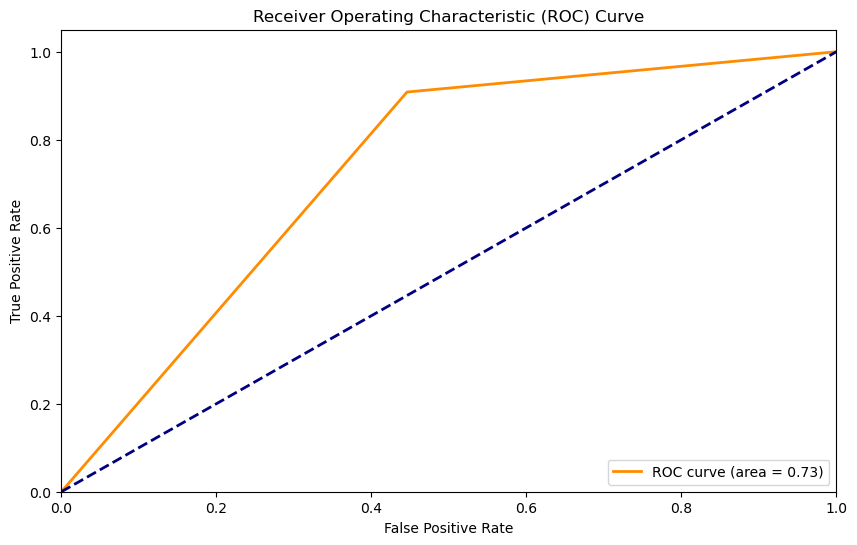

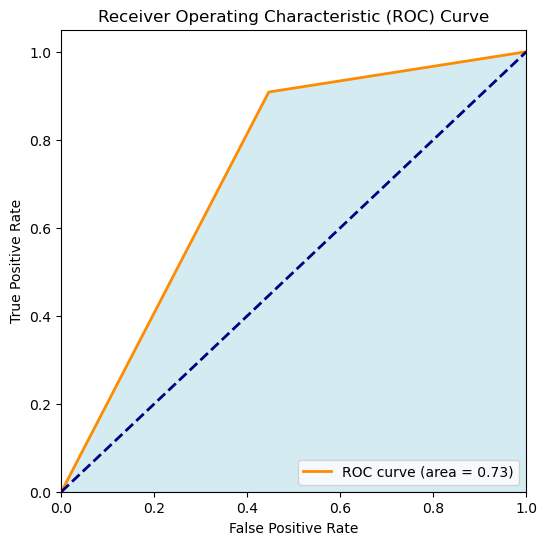

ROC AUC: 0.73


In [126]:
y_pred_prob = pipe_cnb.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test,y_pred)

# SGD Regressor

In [127]:
from sklearn.linear_model import SGDClassifier

pipe_sgd = Pipeline([
    ('preprocessor', preprocessor),
    ('sgd', SGDClassifier(random_state=5))
])

In [128]:
# Fit the pipeline on the training data
pipe_sgd.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(),
                                                  'reviewText'),
                                                 ('numeric', MinMaxScaler(),
                                                  ['audienceScore',
                                                   'runtimeMinutes'])])),
                ('sgd', SGDClassifier(random_state=5))])

In [129]:
# Predict the labels on the test data
y_pred = pipe_sgd.predict(X_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.42      0.55     10800
           1       0.77      0.94      0.85     21752

    accuracy                           0.77     32552
   macro avg       0.78      0.68      0.70     32552
weighted avg       0.77      0.77      0.75     32552

-------------------------------------------------------------
F1 Score: 0.8464661871096729
-------------------------------------------------------------


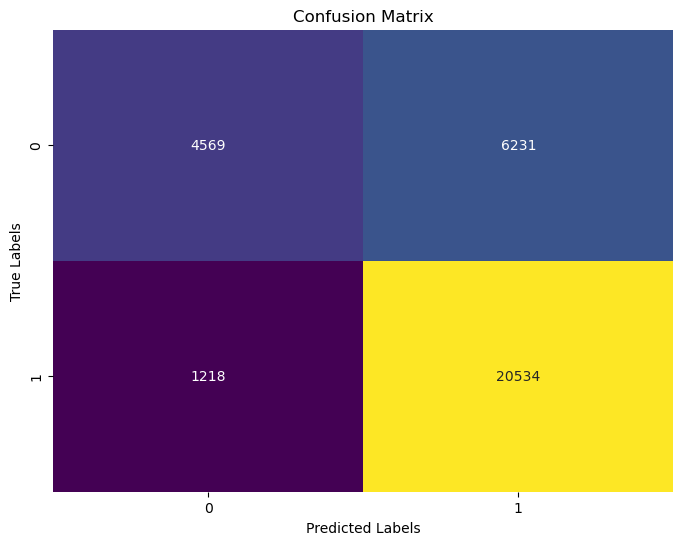

In [130]:
report(X_test, y_test, pipe_sgd)

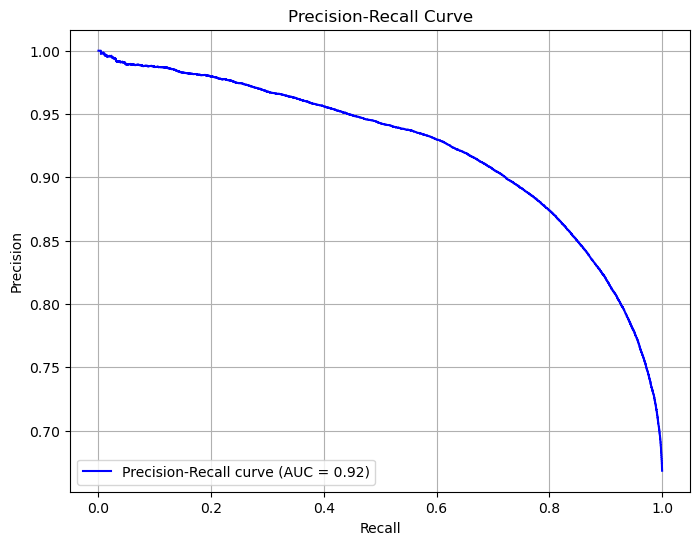

In [131]:
plot_precision_recall_curve_for_pipeline(pipe_sgd, 'sgd', X_train, y_train)

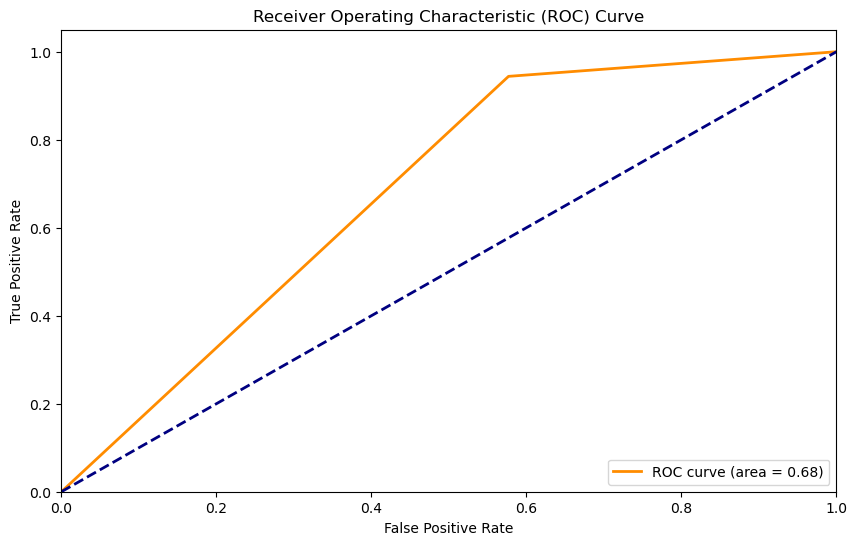

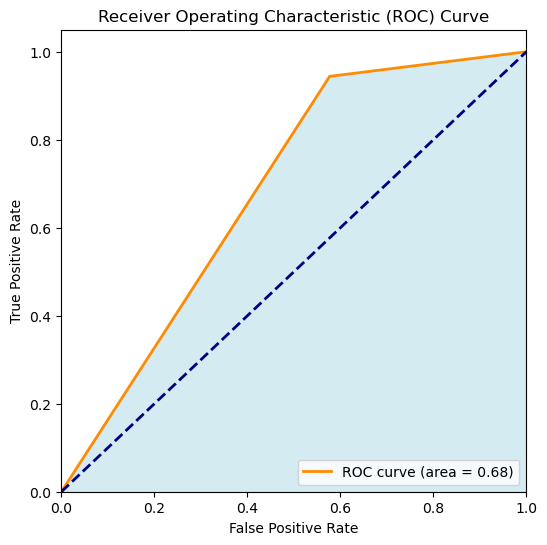

ROC AUC: 0.68


In [132]:
#y_pred_prob = pipe_sgd.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test,y_pred)

# Light Gradient Boosting Model Classifier 

In [133]:
from lightgbm import LGBMClassifier

pipe_lgbm = Pipeline([
    ('preprocessor', preprocessor),  # TF-IDF vectorizer
    ('lgbm', LGBMClassifier(random_state=5))  # LightGBM classifier
])

In [134]:
pipe_lgbm.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(),
                                                  'reviewText'),
                                                 ('numeric', MinMaxScaler(),
                                                  ['audienceScore',
                                                   'runtimeMinutes'])])),
                ('lgbm', LGBMClassifier(random_state=5))])

In [135]:
y_pred = pipe_lgbm.predict(X_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.45      0.55     10800
           1       0.77      0.91      0.83     21752

    accuracy                           0.76     32552
   macro avg       0.74      0.68      0.69     32552
weighted avg       0.75      0.76      0.74     32552

-------------------------------------------------------------
F1 Score: 0.8333754315062726
-------------------------------------------------------------


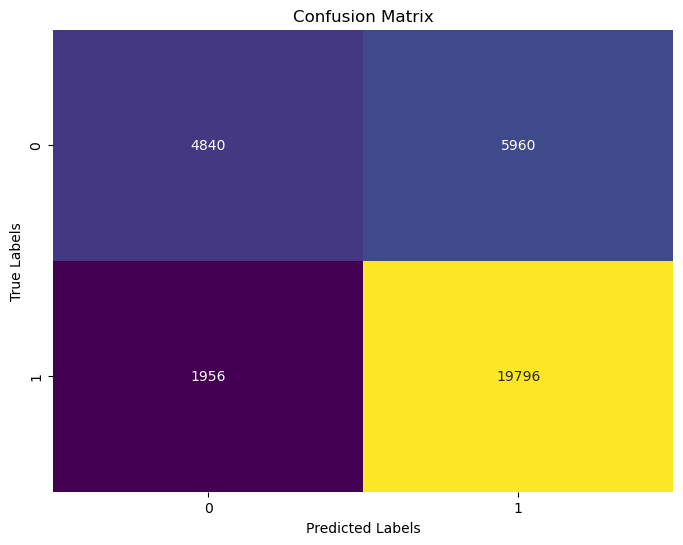

In [136]:
report(X_test, y_test, pipe_lgbm)

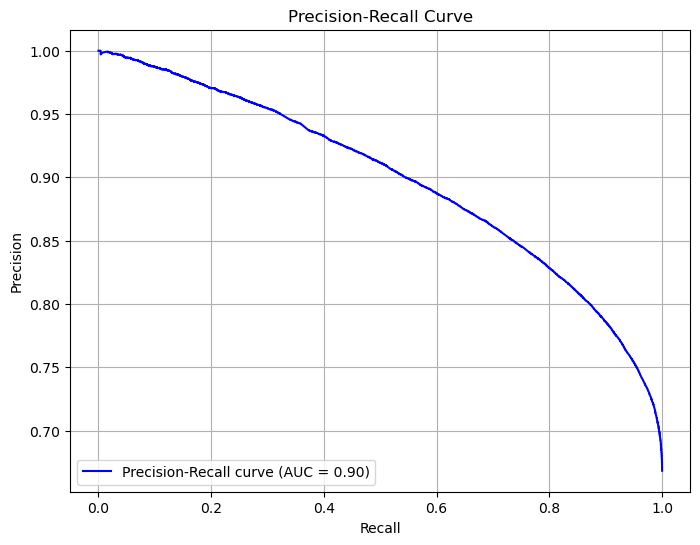

In [137]:
plot_precision_recall_curve_for_pipeline(pipe_lgbm, 'lgbm', X_train, y_train)

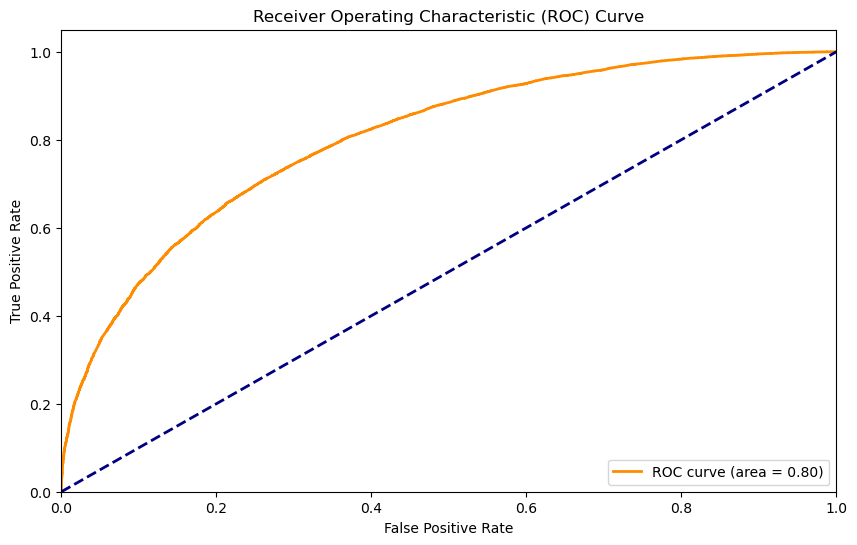

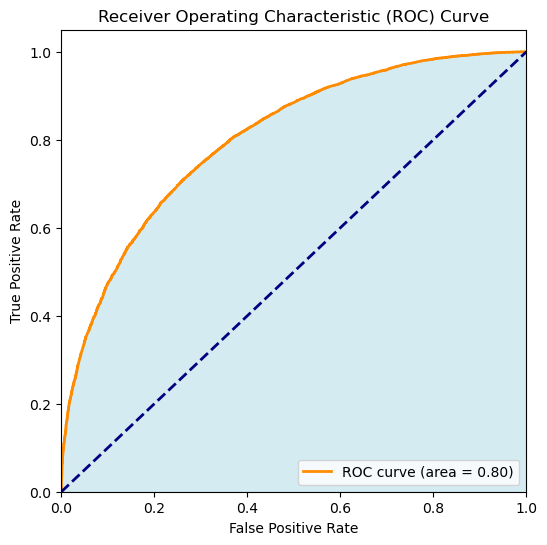

ROC AUC: 0.80


In [138]:
# Calculate predicted probabilities for ROC curve
y_prob_test = pipe_lgbm.predict_proba(X_test)[:, 1]

# Plot ROC curve and calculate ROC AUC score
plot_roc_curve(y_test, y_prob_test)

## Linear SVC

In [139]:
from sklearn.svm import LinearSVC

pipe_svc = Pipeline([
    ('preprocessor', preprocessor),  # TF-IDF vectorizer
    ('svc', LinearSVC(random_state=5,max_iter=2000))  # LinearSVC classifier
])

In [140]:
pipe_svc.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(),
                                                  'reviewText'),
                                                 ('numeric', MinMaxScaler(),
                                                  ['audienceScore',
                                                   'runtimeMinutes'])])),
                ('svc', LinearSVC(max_iter=2000, random_state=5))])

In [141]:
y_pred = pipe_svc.predict(X_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.62      0.67     10800
           1       0.83      0.88      0.85     21752

    accuracy                           0.80     32552
   macro avg       0.78      0.75      0.76     32552
weighted avg       0.79      0.80      0.79     32552

-------------------------------------------------------------
F1 Score: 0.8530247845784845
-------------------------------------------------------------


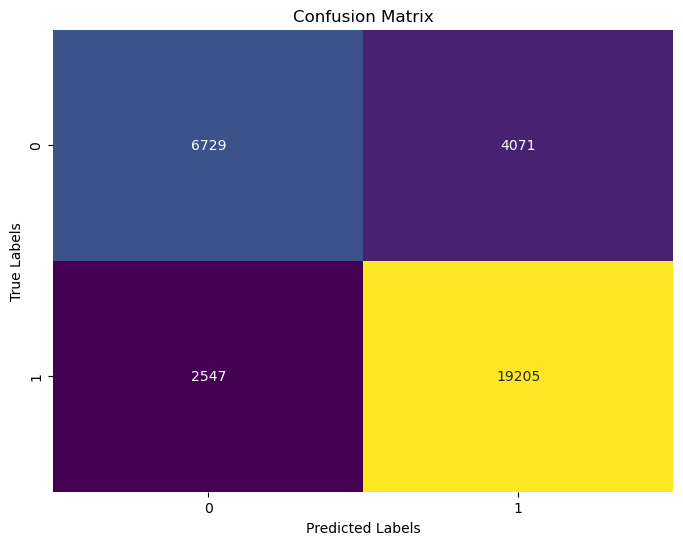

In [142]:
report(X_test, y_test, pipe_svc)

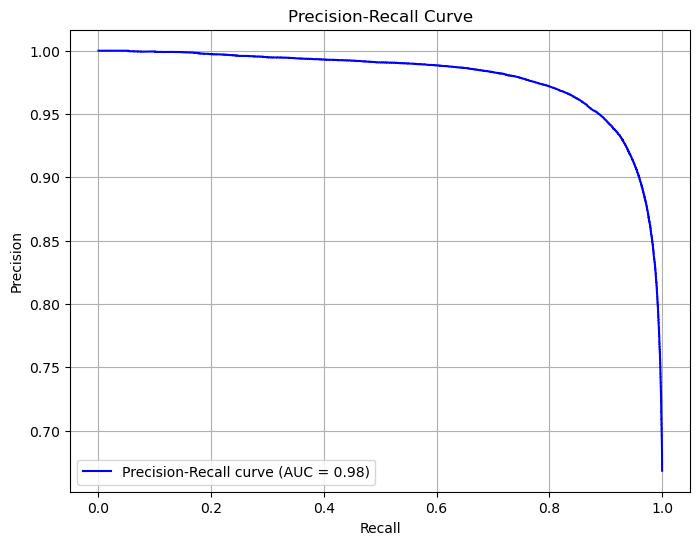

In [143]:
# Plot the precision_recall curve
plot_precision_recall_curve_for_pipeline(pipe_svc, 'svc', X_train, y_train)

### Calibrated SVC

In [144]:
from sklearn.calibration import CalibratedClassifierCV

# Create a calibrated classifier from the LinearSVC
calibrated_svc = CalibratedClassifierCV(pipe_svc)

In [145]:
calibrated_svc.fit(X_train,y_train)

CalibratedClassifierCV(estimator=Pipeline(steps=[('preprocessor',
                                                  ColumnTransformer(transformers=[('tfidf',
                                                                                   TfidfVectorizer(),
                                                                                   'reviewText'),
                                                                                  ('numeric',
                                                                                   MinMaxScaler(),
                                                                                   ['audienceScore',
                                                                                    'runtimeMinutes'])])),
                                                 ('svc',
                                                  LinearSVC(max_iter=2000,
                                                            random_state=5))]))

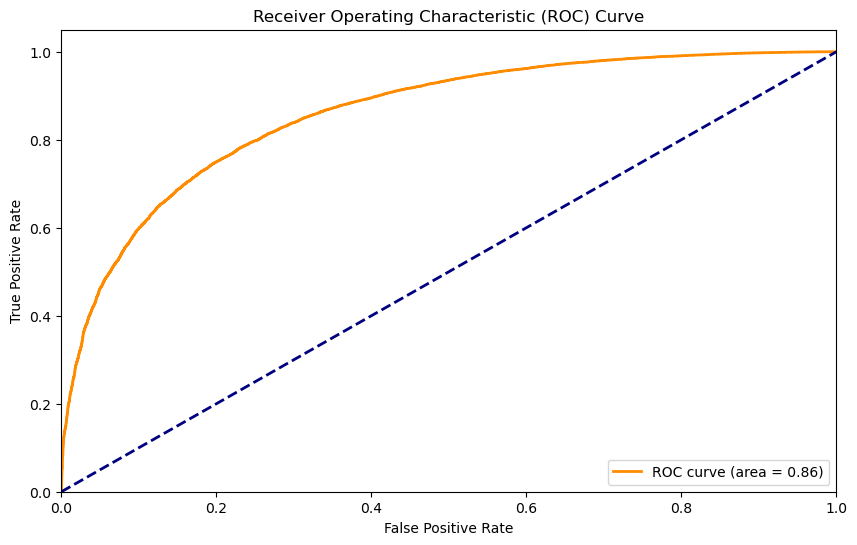

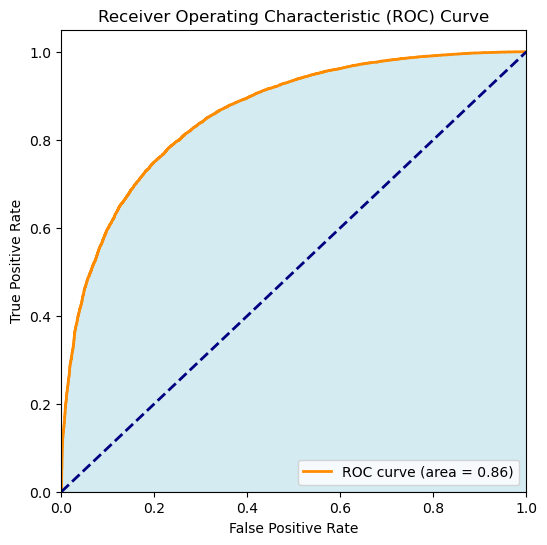

ROC AUC: 0.86


In [146]:
# Calculate predicted probabilities for ROC curve
y_prob_test = calibrated_svc.predict_proba(X_test)[:, 1]

# Plot ROC curve and calculate ROC AUC score
plot_roc_curve(y_test, y_prob_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.59      0.66     10800
           1       0.81      0.90      0.86     21752

    accuracy                           0.80     32552
   macro avg       0.78      0.74      0.76     32552
weighted avg       0.79      0.80      0.79     32552

-------------------------------------------------------------
F1 Score: 0.8561024008373492
-------------------------------------------------------------


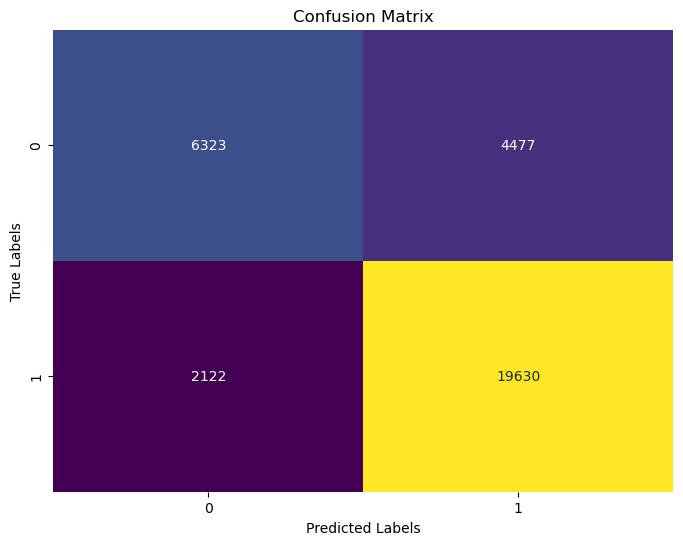

In [147]:
# Print the evaluation report
report(X_test, y_test, calibrated_svc)

## XGBoost

In [148]:
from xgboost import XGBClassifier

# Create a pipeline for XGBoost sentiment analysis
pipe_xgboost = Pipeline([
    ('preprocessor', preprocessor),  
    ('xgboost', XGBClassifier(random_state=42))  # XGBoost classifier
    ])


In [149]:
# Fit the pipeline on the training data
pipe_xgboost.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(),
                                                  'reviewText'),
                                                 ('numeric', MinMaxScaler(),
                                                  ['audienceScore',
                                                   'runtimeMinutes'])])),
                ('xgboost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorica...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [150]:
# Predict on the test data
y_pred = pipe_xgboost.predict(X_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.42      0.53     10800
           1       0.76      0.91      0.83     21752

    accuracy                           0.75     32552
   macro avg       0.73      0.67      0.68     32552
weighted avg       0.74      0.75      0.73     32552

-------------------------------------------------------------
F1 Score: 0.8277682349490972
-------------------------------------------------------------


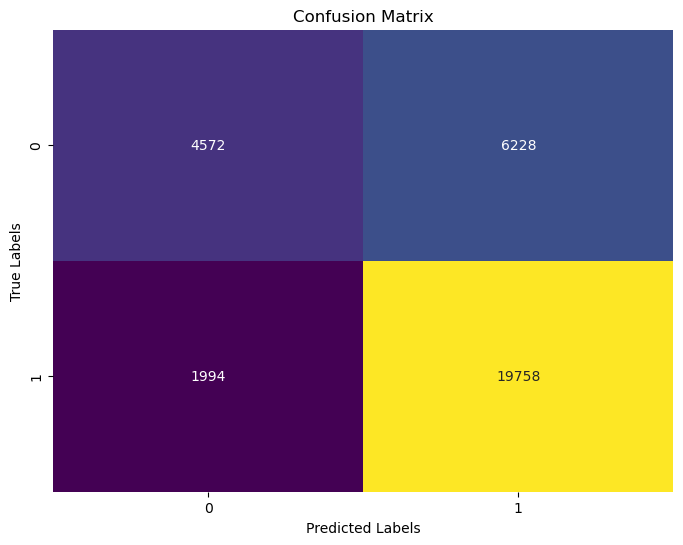

In [151]:
report(X_test, y_test, pipe_xgboost)

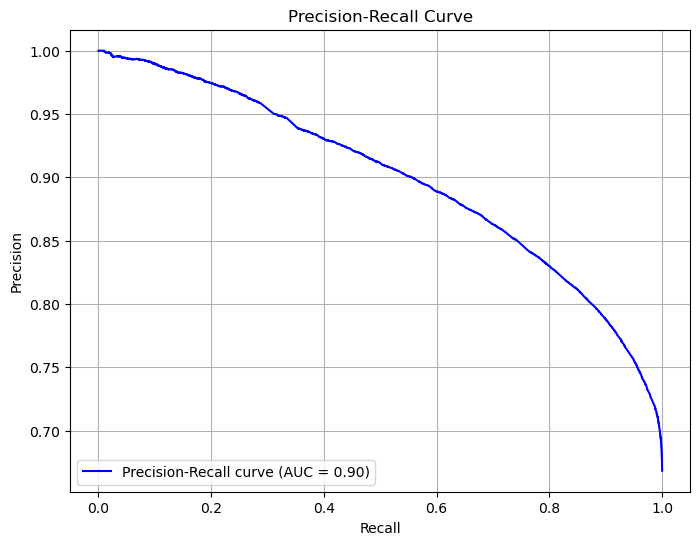

In [152]:
# Plot the precision_recall curve
plot_precision_recall_curve_for_pipeline(pipe_xgboost, 'xgboost', X_train, y_train)

## Comparative Analysis of models

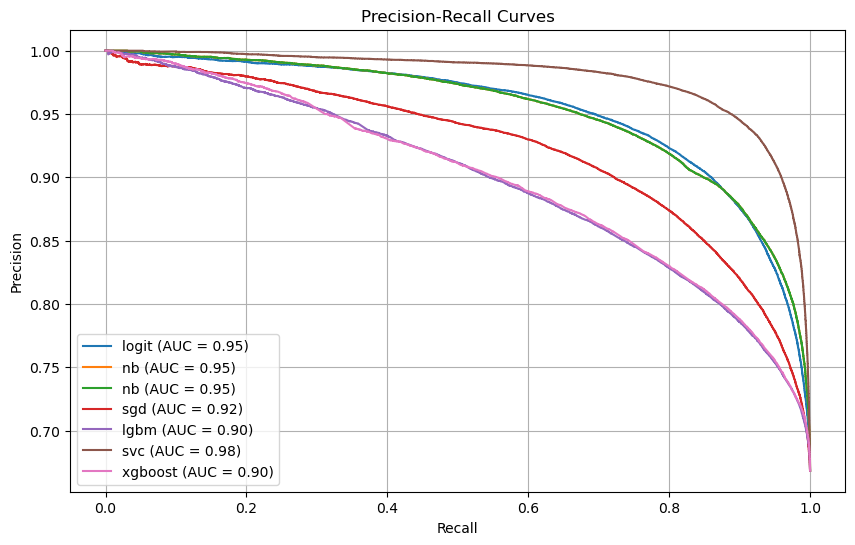

In [153]:
# Define a function to plot precision-recall curve for a pipeline
def agg_precision_recall_curve(pipeline, classifier_step, X_train, y_train):
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities on the training data
    if hasattr(pipeline.named_steps[classifier_step], 'predict_proba'):
        y_scores = pipeline.predict_proba(X_train)[:, 1]
    else:
        y_scores = pipeline.decision_function(X_train)
    
    # Calculate precision-recall values
    precision, recall, _ = precision_recall_curve(y_train, y_scores)
    
    # Calculate area under the curve (AUC)
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve
    plt.plot(recall, precision, label='{} (AUC = {:.2f})'.format(classifier_step, pr_auc))

# Create a list of pipelines and their corresponding classifier step names
pipelines = [
    (pipe_log, 'logit'),
    (pipe_nb, 'nb'),
    (pipe_cnb, 'nb'),
    (pipe_sgd, 'sgd'),
    (pipe_lgbm, 'lgbm'),
    (pipe_svc, 'svc'),
    (pipe_xgboost, 'xgboost')
]

# Create a single plot for all precision-recall curves
plt.figure(figsize=(10, 6))
for pipeline, classifier_step in pipelines:
    agg_precision_recall_curve(pipeline, classifier_step, X_train, y_train)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.show()

#### To identify models with the Highest and lowest TP,FP,TN,FN 

In [154]:
from sklearn.metrics import confusion_matrix, f1_score

# Initialize variables to track lowest and highest TP, FP, FN, FP values
lowest_tp = highest_tp = lowest_fp = highest_fp = lowest_fn = highest_fn = lowest_tn = highest_tn = float('inf')
highest_tp_model = highest_fp_model = highest_fn_model = highest_tn_model = ''
lowest_tp_model = lowest_fp_model = lowest_fn_model = lowest_tn_model = ''

# Calculate and compare TP, FP, FN, and FP for each pipeline
for pipeline, classifier_step in pipelines:
    pipeline_name = classifier_step 
    y_pred = pipeline.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    tp, fp, fn, tn = cm.ravel()
    
    if tp < lowest_tp:
        lowest_tp = tp
        lowest_tp_model = pipeline_name
    if fp < lowest_fp:
        lowest_fp = fp
        lowest_fp_model = pipeline_name
    if fn < lowest_fn:
        lowest_fn = fn
        lowest_fn_model = pipeline_name
    if tn < lowest_tn:
        lowest_tn = tn
        lowest_tn_model = pipeline_name
    
    if tp > highest_tp:
        highest_tp = tp
        highest_tp_model = pipeline_name
    if fp > highest_fp:
        highest_fp = fp
        highest_fp_model = pipeline_name
    if fn > highest_fn:
        highest_fn = fn
        highest_fn_model = pipeline_name
    if tn > highest_tn:
        highest_tn = tn
        highest_tn_model = pipeline_name

    f1 = f1_score(y_test, y_pred)
    
    print(f"Pipeline: {pipeline_name}")
    print(f"True Positives: {tp}, False Positives: {fp}, False Negatives: {fn}, True Negatives: {tn}")
    print(f"F1 Score: {f1:.2f}")
    print("-------------------------------------------------------------")

print("Models with the highest values:")
print(f"TP: {highest_tp_model}, FP: {highest_fp_model}, FN: {highest_fn_model}, TN: {highest_tn_model}")
print("Models with the lowest values:")
print(f"TP: {lowest_tp_model}, FP: {lowest_fp_model}, FN: {lowest_fn_model}, TN: {lowest_tn_model}")


Pipeline: logit
True Positives: 6266, False Positives: 4534, False Negatives: 1933, True Negatives: 19819
F1 Score: 0.86
-------------------------------------------------------------
Pipeline: nb
True Positives: 2725, False Positives: 8075, False Negatives: 340, True Negatives: 21412
F1 Score: 0.84
-------------------------------------------------------------
Pipeline: nb
True Positives: 5984, False Positives: 4816, False Negatives: 1993, True Negatives: 19759
F1 Score: 0.85
-------------------------------------------------------------
Pipeline: sgd
True Positives: 4569, False Positives: 6231, False Negatives: 1218, True Negatives: 20534
F1 Score: 0.85
-------------------------------------------------------------
Pipeline: lgbm
True Positives: 4840, False Positives: 5960, False Negatives: 1956, True Negatives: 19796
F1 Score: 0.83
-------------------------------------------------------------
Pipeline: svc
True Positives: 6729, False Positives: 4071, False Negatives: 2547, True Negative

In [155]:
from sklearn.metrics import f1_score

# List to store the F1 scores
f1_scores = []

# Calculate F1 scores for each pipeline
for pipeline, classifier_step in pipelines:
    pipeline_name = classifier_step  # You can customize this name
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append((pipeline_name, f1))

# Sort the F1 scores in descending order
f1_scores_sorted = sorted(f1_scores, key=lambda x: x[1], reverse=True)

# Print the F1 scores
print("F1 Scores in Descending Order:")
for model, score in f1_scores_sorted:
    print(f"Model: {model}, F1 Score: {score:.2f}")


F1 Scores in Descending Order:
Model: logit, F1 Score: 0.86
Model: svc, F1 Score: 0.85
Model: nb, F1 Score: 0.85
Model: sgd, F1 Score: 0.85
Model: nb, F1 Score: 0.84
Model: lgbm, F1 Score: 0.83
Model: xgboost, F1 Score: 0.83


In [156]:
# Deciding the best model

best_model_name, best_f1_score = f1_scores_sorted[0]
print(f"The best model is {best_model_name} with an F1 score of {best_f1_score:.2f}")


The best model is logit with an F1 score of 0.86


In [157]:
from sklearn.metrics import auc, precision_recall_curve

# List to store the AUC-PR scores
pr_auc_scores = []

# Calculate AUC-PR for each pipeline
for pipeline, classifier_step in pipelines:
    pipeline_name = classifier_step  # You can customize this name
    
    # Predict probabilities on the test data
    if hasattr(pipeline.named_steps[classifier_step], 'predict_proba'):
        y_scores = pipeline.predict_proba(X_test)[:, 1]
    else:
        y_scores = pipeline.decision_function(X_test)
    
    # Calculate precision-recall values
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    
    # Calculate AUC-PR
    pr_auc = auc(recall, precision)
    pr_auc_scores.append((pipeline_name, pr_auc))

# Sort the AUC-PR scores in descending order
pr_auc_scores_sorted = sorted(pr_auc_scores, key=lambda x: x[1], reverse=True)

# Print the AUC-PR scores
print("AUC-PR Scores in Descending Order:")
for model, score in pr_auc_scores_sorted:
    print(f"Model: {model}, AUC-PR Score: {score:.2f}")

# Decide the best model based on the highest AUC-PR
best_model_name, best_pr_auc_score = pr_auc_scores_sorted[0]
print(f"\nThe best model is {best_model_name} with an AUC-PR score of {best_pr_auc_score:.2f}")


AUC-PR Scores in Descending Order:
Model: logit, AUC-PR Score: 0.92
Model: nb, AUC-PR Score: 0.92
Model: nb, AUC-PR Score: 0.92
Model: svc, AUC-PR Score: 0.92
Model: sgd, AUC-PR Score: 0.91
Model: lgbm, AUC-PR Score: 0.89
Model: xgboost, AUC-PR Score: 0.88

The best model is logit with an AUC-PR score of 0.92


# Summary(without Hyper-parameter Tuning)

## Model summary without hyper-parameter tuning
 
> In terms of accuracy,the top performing models without hyper-parameter tuning are: **LogisticRegressor,Calibrated LinearSVC with 80%, Complement Naive Bayes** with an accuracy of **79%**

> However, since the evaluation metric for our case is the F1-score, the top models are:

>>**LogisticRegressor** with **0.86**

>>**CalibratedSVC** with **0.85**

>>**ComplementNB** with **0.85**

> On closer inspection of the **Precision-Recall** curves, it is noticed that **LogisticRegressor** performs the best classification, with a **AUC-PR** of **0.92** followed by **NaiveBayes,SVC** with a similar score of **0.92**


> **LogisticRegression** is the **best classifier** for a **non-hypertuned model** in our use-case.

## Comparision of models

> The **"logit"** model has the **highest F1** score of **0.86**, indicating the best balance between precision and recall among the models. This could be an important aspect for businesses where both false positives and false negatives are equally costly.

> The "nb" model is listed twice with different results, possibly indicating two variations or settings. If so, this showcases how hyperparameter tuning can significantly affect the performance of a model.


#### - True Positives (TP):

High TP values indicate a model's effectiveness in correctly identifying positive sentiments. This is crucial for businesses looking to understand customer satisfaction with products or services. For instance:

> **Highest TP**: The "svc" model, with the highest true positives, could be useful in identifying happy customers, potentially leading to targeted marketing or retention strategies.

>**Lowest TP**:  The "nb" model with the lowest true positives might miss opportunities to capitalize on satisfied customers.

#### - False Positives (FP): 
High FP values mean that the model incorrectly identifies negative sentiments as positive. This could mislead businesses into thinking that customers are satisfied when they are not.

> **Highest FP** :  The "nb" model might cause a business to overestimate satisfaction levels.

> **Lowest FP**: The "svc" model appears to be more conservative, which might be preferable in certain contexts.


#### - False Negatives (FN):
 A high FN value indicates that the model is failing to identify positive sentiments, which might lead to overlooking satisfied customers or not addressing areas where the business is performing well.

> **Highest FN**: The "svc" model might cause missed opportunities for leveraging positive feedback.

>**Lowest FN**: The "nb" model's low false negatives make it suitable for capturing most of the positive sentiments, despite its other shortcomings.

#### - True Negatives (TN):
High TN values reflect the model's ability to correctly identify negative sentiments. This is crucial for recognizing areas for improvement or potential issues.

> **Highest TN**: The "sgd" model might be best for pinpointing dissatisfied customers and understanding their concerns.

>**Lowest TN**: The "svc" model's low true negatives might result in failing to identify critical areas for improvement.


### Brand Monitoring and Reputation Management:

High F1 Scores indicate models that are effective in balancing the recognition of both positive and negative sentiments. This can be used for tracking public opinions about a brand or products and responding accordingly.

<code style="background:red;color:white">**Best Overall Performance:** The **"logit"** model, with an F1 score of **0.86**, might be best suited for general brand monitoring, and also track customer feedback and product reviews.</code>



# Hyper-parameter Tuning

### Logistic Regression

In [158]:
# # Define the parameter grid
# param_grid_log = {
#     'preprocessor__tfidf__max_features': [1000, 5000], # 2 options
#     'preprocessor__tfidf__ngram_range': [(1, 1)], # 1 option
#     'logit__penalty': ['l1', 'l2'], # 2 options
#     'logit__C': [0.1, 1], # 2 options
#     'logit__fit_intercept': [True, False], # 2 options
#     'logit__solver': ['liblinear','saga'], # 1 option
#     'logit__class_weight': [None], # 1 option
#     'logit__max_iter': [100, 500] # 2 options
# }

# # Create the grid search object
# grid_search_log = GridSearchCV(pipe_log, param_grid_log, cv=5, verbose=1, scoring='f1') # You can change the scoring to any other appropriate metric

# # Fit the grid search on the training data
# grid_search_log.fit(X_train, y_train)


In [159]:
# from sklearn.model_selection import GridSearchCV

# # Now you can access the best_params_ and best_estimator_ attributes
# best_params = grid_search_log.best_params_
# best_estimator = grid_search_log.best_estimator_

In [160]:
# # Evaluate the best estimator on the test data
# score = best_estimator.score(X_test, y_test)
# score

In [161]:
#score=0.7901204227082821

In [162]:
# # Get the predictions for the test data
# y_pred = best_estimator.predict(X_test)

In [163]:
# # Print best hyperparameters and classification report
# print("Best Hyperparameters:", best_params)

In [164]:
#Best Hyperparameters: {'logit__C': 1, 'logit__class_weight': None, 'logit__fit_intercept': True, 'logit__max_iter': 100, 'logit__penalty': 'l1', 'logit__solver': 'liblinear', 'preprocessor__tfidf__max_features': 5000, 'preprocessor__tfidf__ngram_range': (1, 1)}

In [165]:
# report(X_test, y_test, grid_search_log)

#### Saving the hyper-tuned LogisticRegression model

In [166]:
# import pickle

# # Save the model to a file
# with open('best_logistic_model.pkl', 'wb') as f:
#     pickle.dump(grid_search_log, f)

# # You can also save the best parameters separately if needed
# with open('best_logistic_params.pkl', 'wb') as f:
#     pickle.dump(best_params, f)

# print("Model and parameters saved successfully!")

In [167]:
# # Load the model from the file
# with open('best_logistic_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# # Load the best parameters from the file
# with open('best_logistic_params.pkl', 'rb') as f:
#     loaded_best_params = pickle.load(f)

# # You can now use loaded_model and loaded_best_params in your code
# print("Loaded Best Hyperparameters:", loaded_best_params)

### Hypertuning the SVC Model

In [168]:
# # Create a calibrated classifier from the LinearSVC
# calibrated_svc = CalibratedClassifierCV(base_estimator=pipe_svc)

# # Define the parameter grid
# param_grid_calibrated_svc = {
#     'base_estimator__preprocessor__tfidf__max_features': [1000, 3000], # Maximum number of features for TF-IDF
#     'base_estimator__preprocessor__tfidf__ngram_range': [(1, 1), (1, 2)], # Unigrams or bigrams
#     'base_estimator__svc__C': [0.1, 1, 10], # Regularization parameter
#     'base_estimator__svc__loss': ['hinge'], # Specifies the loss function
#     'base_estimator__svc__penalty': ['l2'], # Specifies the norm used in the penalization
#     'base_estimator__svc__fit_intercept': [True], # Specifies if a constant should be added to the decision function
#     'base_estimator__svc__max_iter': [1000], # Maximum number of iterations for the solvers to converge
#     'base_estimator__svc__class_weight': [None], # Weights associated with classes
#     'base_estimator__svc__multi_class': ['ovr'] # Determines the multi-class strategy
# }


# # Create the grid search object
# grid_calibrated_svc = GridSearchCV(calibrated_svc, param_grid_calibrated_svc, cv=5, verbose=1, scoring='f1') # You can change the scoring to any other appropriate metric

# # Fit the grid search on the training data
# grid_calibrated_svc.fit(X_train, y_train)


In [169]:
# print("Best parameters for Calibrated LinearSVC:", grid_calibrated_svc.best_params_)

In [170]:
# score = best_estimator.score(X_test, y_test)
# score

In [171]:
# score=0.7901204227082821

In [172]:
# # Evaluate the best Calibrated LinearSVC model
# report(X_test, y_test, grid_calibrated_svc)


#### Saving the hyper-tuned SVC model

In [173]:
# # Save the Calibrated LinearSVC model to a file
# with open('best_calibrated_svc_model.pkl', 'wb') as f:
#     pickle.dump(grid_calibrated_svc, f)

# # Save the best parameters of the Calibrated LinearSVC model to a file
# best_params_calibrated_svc = grid_calibrated_svc.best_params_
# with open('best_calibrated_svc_params.pkl', 'wb') as f:
#     pickle.dump(best_params_calibrated_svc, f)

# print("Calibrated LinearSVC model and parameters saved successfully!")


In [174]:
# # Load the Calibrated LinearSVC model from the file
# with open('best_calibrated_svc_model.pkl', 'rb') as f:
#     loaded_calibrated_svc_model = pickle.load(f)

# # Load the best parameters of the Calibrated LinearSVC model from the file
# with open('best_calibrated_svc_params.pkl', 'rb') as f:
#     loaded_best_calibrated_svc_params = pickle.load(f)

# # You can now use loaded_calibrated_svc_model and loaded_best_calibrated_svc_params in your code
# print("Loaded Best Hyperparameters for Calibrated LinearSVC:", loaded_best_calibrated_svc_params)


In [175]:
#Loaded Best Hyperparameters for Calibrated LinearSVC: {'base_estimator__preprocessor__tfidf__max_features': 3000, 'base_estimator__preprocessor__tfidf__ngram_range': (1, 1), 'base_estimator__svc__C': 1, 'base_estimator__svc__class_weight': None, 'base_estimator__svc__fit_intercept': True, 'base_estimator__svc__loss': 'hinge', 'base_estimator__svc__max_iter': 1000, 'base_estimator__svc__multi_class': 'ovr', 'base_estimator__svc__penalty': 'l2'}

# Summary
### Model summary after Hyper-parameter tuning a couple of models

> The scores went down for both **LogisticRegression** and **LinearSVC**.
> This might be due to several reasons, one being overfitting or choosing unfavourable parameters, further tuning of the parameters is required to arrive at the best set of parameters.

#### Making the submission.csv

In [195]:
def submission_csv(y_pred):
    # Map 1 to 'Positive' and 0 to 'Negative'
    sentiment_mapping = {1: 'POSITIVE', 0: 'NEGATIVE'}
    y_pred_labels = [sentiment_mapping[pred] for pred in y_pred]

    # Create a DataFrame with the predicted labels
    submission = pd.DataFrame({'id': range(len(y_pred_labels)), 'sentiment': y_pred_labels})

    # Save the DataFrame to the submission.csv file
    submission_file = "submission.csv"
    submission.to_csv(submission_file, index=False)  # Set index=False to remove the index column
    
    print(f'{submission_file} has been created successfully')
    print('Contents of the submission file:')
    #print(submission)
    return submission


# Create a DataFrame with the required columns
test_data_for_submission = merged_test_data[['reviewText', 'audienceScore', 'runtimeMinutes']]

# Make predictions on the actual test dataset for submission
y_pred_submission = pipe_log.predict(test_data_for_submission)

submission_csv(y_pred_submission)

submission.csv has been created successfully
Contents of the submission file:


,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,POSITIVE
55311,55311,NEGATIVE
55312,55312,NEGATIVE
55313,55313,POSITIVE


In [193]:
sample_data

,id,sentiment
0,0,NEGATIVE
1,1,NEGATIVE
2,2,NEGATIVE
3,3,NEGATIVE
4,4,NEGATIVE
...,...,...
55310,55310,NEGATIVE
55311,55311,NEGATIVE
55312,55312,NEGATIVE
55313,55313,NEGATIVE


In [196]:
y_pred_submission.shape

(55315,)

___________________________________________________________________________________________________________________